## Projection Pursuit Multivariate Sampling of Parameter Uncertainty

<i> Oktay Erten, Fabio Pereira, Clayton V. Deutsch <i>
    
This notebook indicates the implementation of several sampling techniques including Monte Carlo simulation (MCS), Latin hypercube sampling (LHS), Maximin Latin hypercube sampling (Maximin LHS), Latin hypercube sampling with multidimensional uniformity (LHSMDU) and projection pursuit multivariate transform (PPMT) considering the case where the variables are linearly correlated. 

#### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import pygeostat as gs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from IPython.display import display, Math, Latex
from IPython.display import Image
import sys
import random
import warnings
import seaborn as sns
from skopt.space import Space
from scipy.stats import spearmanr, pearsonr
import math
from tqdm.notebook import tqdm_notebook
from matplotlib.pyplot import figure
from time import sleep
import time
import os
from scipy import stats
import scipy
import scipy.linalg
import pprint
from matplotlib import cm
from skopt.sampler import Lhs
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import savetxt
from scipy.spatial.distance import pdist
from scipy.stats import gamma
from skopt.sampler import Sobol
from pyDOE import lhs
from __future__ import absolute_import, division, print_function, unicode_literals
from numpy.linalg import norm
from numpy import array, random, matrix, zeros, triu_indices, sum, sort, argsort, ravel, max, min as minimum, mean, argpartition 
from scipy.stats import rv_continuous, rv_discrete
from scipy.stats.distributions import rv_frozen
from scipy.spatial.distance import pdist, squareform
import lhsmdu
from matplotlib import collections as mc
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import truncnorm
from statsmodels.formula.api import ols
import matplotlib as mpl
import sympy as sym
from collections import OrderedDict

warnings.filterwarnings('ignore')
%autosave 60
%matplotlib inline

print (' ')
print ('The versions of the python packages are given as follows:')
print (' ')
print ('Python version    :', sys.version_info)
print ('Numpy version     :', np.__version__)
print ('Pandas version    :', pd.__version__)
print ('Pygeostat version :', gs.__version__)
print ('Scipy version     :', scipy.__version__)
print ('Matplotlib        :', mpl.__version__)

Autosaving every 60 seconds
 
The versions of the python packages are given as follows:
 
Python version    : sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
Numpy version     : 1.21.2
Pandas version    : 1.3.4
Pygeostat version : 1.1.1
Scipy version     : 1.7.1
Matplotlib        : 3.4.3


#### Pandas configuration options

In [2]:
pd.set_option ('display.max_columns', 700)
pd.set_option ('display.max_rows', 400)
pd.set_option ('display.min_rows', 10)
pd.set_option ('display.expand_frame_repr', True)

#### Set the style parameters

In [3]:
plt.rcParams ['figure.figsize'] = (5.0, 5.0)
#plt.style.use('seaborn-dark-palette')
plt.rcParams ['axes.grid'] = True
plt.rcParams ["patch.force_edgecolor"] = True
sns.set()

#### Display the path for the working directory

In [4]:
print ('----------------------------------------------------------- ')
print ('The working directory for this study is given as follows:')
print ('----------------------------------------------------------- ')
print (' ')
print (os.getcwd ())

----------------------------------------------------------- 
The working directory for this study is given as follows:
----------------------------------------------------------- 
 
C:\Users\erten\Desktop\github_ppmt_sampling


#### Set the path for the new working directory 

In [5]:
os.chdir(r'C:\Users\erten\Desktop\github_ppmt_sampling')
print ('------------------------------------------------------------- ')
print ('The new working directory for this study is given as follows:')
print ('------------------------------------------------------------- ')
print (' ')
print (os.getcwd ())

------------------------------------------------------------- 
The new working directory for this study is given as follows:
------------------------------------------------------------- 
 
C:\Users\erten\Desktop\github_ppmt_sampling


#### Set a path to `GSLIB` programs' folder

In [6]:
exedir = 'exes/'
outdir = 'output/'
gs.mkdir = (outdir)

#### Functions for `CLHS` and `Maximin LHS` sampling

In [7]:
"""
This code was originally published by the following individuals for use with
Scilab:
    Copyright (C) 2012 - 2013 - Michael Baudin
    Copyright (C) 2012 - Maria Christopoulou
    Copyright (C) 2010 - 2011 - INRIA - Michael Baudin
    Copyright (C) 2009 - Yann Collette
    Copyright (C) 2009 - CEA - Jean-Marc Martinez
    
    website: forge.scilab.org/index.php/p/scidoe/sourcetree/master/macros
Much thanks goes to these individuals. It has been converted to Python by 
Abraham Lee.
"""

'''Classic latin hypercube sampling'''

def _lhsclassic (n, samples):
    
    # Generate the intervals
    cut = np.linspace (0, 1, samples + 1)    
    
    # Fill points uniformly in each interval
    u = np.random.rand (samples, n)
    a = cut [:samples]
    b = cut [1:samples + 1]
    rdpoints = np.zeros_like(u)
    for j in range(n):
        rdpoints [:, j] = u [:, j] * (b - a) + a
    
    # Make the random pairings
    H = np.zeros_like (rdpoints)
    for j in range(n):
        order = np.random.permutation (range (samples))
        H [:, j] = rdpoints [order, j]
    
    return H


'''Calculate the pair-wise point distances of a matrix'''

def _pdist (x):
   
    x = np.atleast_2d (x)
    assert len (x.shape) == 2, 'Input array must be 2d-dimensional'
    
    m, n = x.shape
    if m < 2:
        return []
    
    d = []
    for i in range (m - 1):
        for j in range (i + 1, m):
            d.append ((sum ((x [j, :] - x [i, :]) ** 2)) ** 0.5)
    
    return np.array (d)


'''Maximin latin hypercube sampling'''

def _lhsmaximin (n, samples, iterations, lhstype):
    maxdist = 0
    
    # Maximize the minimum distance between points
    for i in range (iterations):
        if lhstype == 'maximin':
            Hcandidate = _lhsclassic (n, samples)
        else:
            Hcandidate = _lhscentered (n, samples)
        
        d = _pdist (Hcandidate)
        if maxdist < np.min (d):
            maxdist = np.min (d)
            H = Hcandidate.copy()
    
    return H

#### Function for creating a covariance matrix using the given inputs

In [8]:
def cov_mat (var = [], corr = []):
    
    '''This function creates a symmetric covariance matrix using the 
    variance and covariance values given by the user. It is noted that
    the variance and covariance values should be given in order. For 
    example, Variance (variable1), Variance (variable2), ..., and
    Covariance (variable1 - variable2), Covariance (variable1 - variable3),
    ...'''
    
    if (len (var) * (len (var) + 1)) / 2 != len (var) + len (corr):
        print ('Please check the inputs again...') 
        sys.exit ()
    
    else:
        a = np.zeros ((len (var), len (var)), dtype = float)
        np.fill_diagonal (a, var)
        
        a[np.triu_indices (len (var), 1)] = corr
        i_lower = np.tril_indices (len (var), -1)
        a [i_lower] = a.T [i_lower]
    
    print (' ')
    print ('The covariance matrix for the given inputs is as follows:')
    print (' ')
    display (a)
    return a

#### Function for loading the seed numbers

In [9]:
def SeedVal (datafl, colname):
    x = int (input ('Enter the number of realizations needed: '))
    list_seed = []
    for i in tqdm_notebook (range (x), total = x, desc = 'Loop 1'):
        seeds = pd.read_csv (datafl)
        b = seeds [colname][i]
        list_seed.append (b)
        del b
        time.sleep (0.0000000001)
        
    return list_seed

### Original Oil in Place Example

Example on the original oil in place (OOIP). OOIP can be calculated as follows:

$$\textrm{OOIP} = \textrm{CAT} \times \textrm{NTG} \times \phi_{net} (1-\textrm{S}_{\textrm{w}})$$

where $\textrm{C}=1$ is the constant to account for units; $\textrm{A}$ is the deposit area; $\textrm{T}$ is the thickness of the deposit; $\textrm{NTG}$ is the net oil to gross volume; $\phi_{net}$ is the net porosity and $\textrm{S}_{\textrm{w}}$ is the water saturation. The parametric distributions and parameters used for $\textrm{OOIP}$ variables are given as follows:

* $\textrm{A}$, Triangular, $a=2$, $b=4$, $c=6$ 
* $\textrm{T}$, Gaussian,  $m=10$, $\sigma=4$
* $\textrm{NTG}$, Uniform, $a=0.6$, $b=0.8$
* $\phi_{net}$, Truncated triangular, $a=0.15$, $b=0.25$, $c=0.35$
* $\textrm{S}_{\textrm{w}}$, Triangular, $a=0.15$, $b=0.2$, $c=0.3$

#### Generate 10 million realizations of the OOIP variables with given parameters

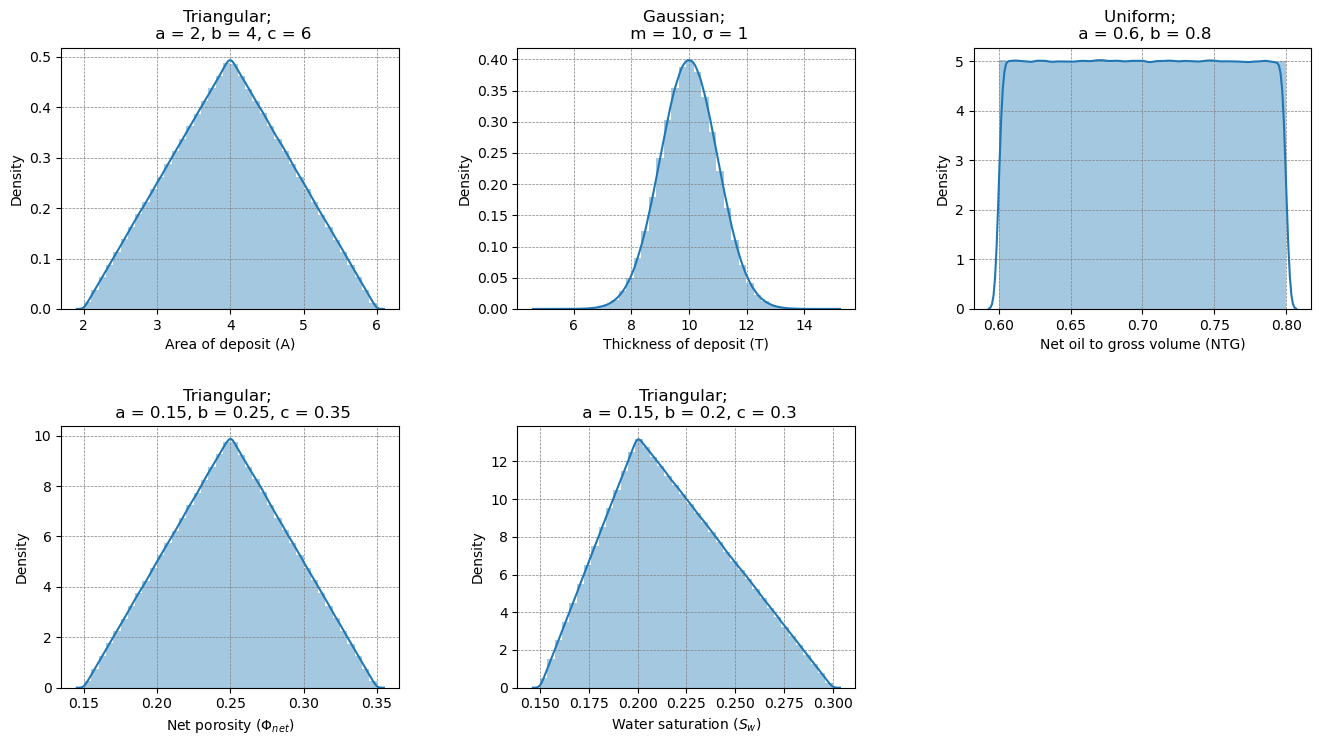

 
Current processor time (in seconds): 261.22018929999996


In [10]:
t0 = time.perf_counter()

mpl.style.use('default')
fig, axes = plt.subplots(2, 3, figsize = (20, 8))

area = np.random.triangular (2, 4, 6, 10000000)
sns.distplot (area, bins = 40, ax = axes [0, 0])
axes[0, 0].set (xlabel = 'Area of deposit (A)', ylabel = 'Density')
axes[0, 0].set_title ('Triangular; \n a = 2, b = 4, c = 6')
axes [0, 0].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

thick = np.random.normal(10, 1, 10000000)
sns.distplot (thick, bins = 40, ax = axes [0, 1])
axes [0, 1].set (xlabel = 'Thickness of deposit (T)', ylabel = 'Density')
axes[0, 1].set_title ('Gaussian; \n m = 10, \u03C3 = 1')
plt.xlim (-5, 25)
axes [0, 1].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

net_oil = np.random.uniform (0.6, 0.8, 10000000)
sns.distplot (net_oil, bins = 40, ax = axes [0, 2])
axes[0, 2].set (xlabel = 'Net oil to gross volume (NTG)', ylabel = 'Density')
axes[0, 2].set_title ('Uniform; \n a = 0.6, b = 0.8')
axes[0, 2].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

net_poros = np.random.triangular (0.15, 0.25, 0.35, 10000000)
sns.distplot (net_poros, bins = 40, ax = axes [1, 0])
axes[1, 0].set (xlabel = 'Net porosity (\u03A6'+'$_{net}$)', ylabel = 'Density')
axes[1, 0].set_title ('Triangular; \n a = 0.15, b = 0.25, c = 0.35')
axes[1, 0].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

water_sat = np.random.triangular (0.15, 0.2, 0.3, 10000000)
sns.distplot (water_sat, bins = 40, ax = axes [1, 1])
axes[1, 1].set (xlabel = 'Water saturation '+ '($S_{w}$)', ylabel = 'Density')
axes[1, 1].set_title ('Triangular; \n a = 0.15, b = 0.2, c = 0.3')
axes[1, 1].grid (color = 'gray', linestyle = '--', linewidth = 0.5)
fig.delaxes (axes[1][2])

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.45)        
plt.savefig (outdir + 'figures/figure_1.png', bbox_inches = 'tight', dpi = 300)
plt.show ()
t1 = time.perf_counter() - t0
print (' ')
print ('Current processor time (in seconds):', t1)

#### Generate the OOIP population (underlying) distribution based on the equation given above

In [11]:
constant = 1
ooip = constant * area * thick * net_oil * (net_poros * (1 - water_sat))
ooip

array([5.78155044, 7.69695573, 6.70151879, ..., 6.97657035, 4.3724329 ,
       5.75726929])

#### Function for calculating the empirical cumulative distribution function

In [12]:
def ecdf(data):
    
    """Compute ECDF for a one-dimensional 
    array of measurements."""
    
    n = len (data)
    x = np.sort (data)
    y = np.arange (1, n + 1) / n

    return x, y

#### Calculate the cumulative distribution functions of the five variables of OOIP

In [13]:
varias = [area, thick, net_oil, net_poros, water_sat]
results = []

for i in tqdm_notebook (varias, total = len (varias), desc = 'Loop 1'):
    kk = ecdf (i)
    results.append (kk)
    del kk
    time.sleep (0.0000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

#### Plot the empirical cumulative distribution functions of the five variables of OOIP

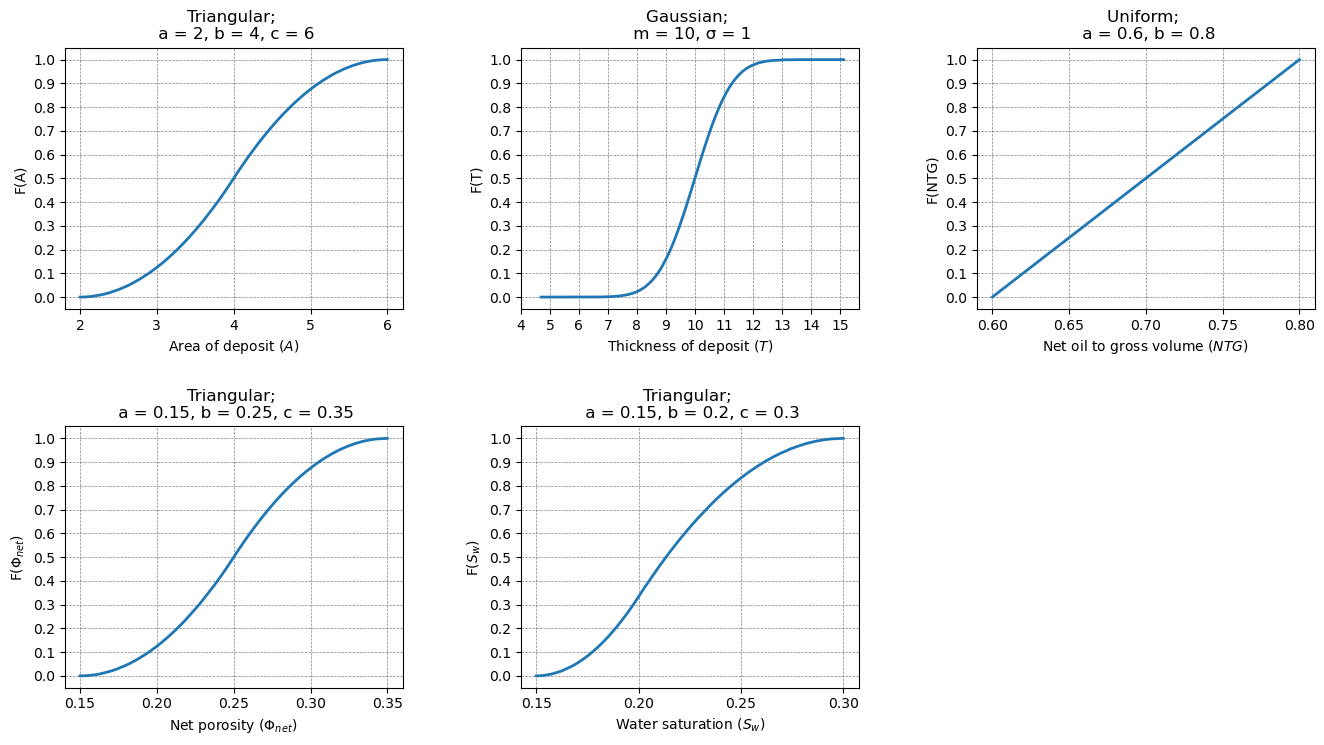

In [14]:
mpl.style.use('default')
fig, axes = plt.subplots(2, 3, figsize = (20, 8)) 

axes [0, 0].plot (results [0][0], results [0][1], linestyle = '-', linewidth = 2)
axes[0, 0].set (xlabel = 'Area of deposit ($A$)', ylabel = 'F(A)')
axes[0, 0].set_title ('Triangular; \n a = 2, b = 4, c = 6')
plt.xlim (2, 6)
plt.ylim (-0.02, 1.02)
axes [0, 0].set_yticks (np.arange(0,1.1,0.1))
axes [0, 0].set_xticks (np.arange(2,7,1))
axes [0, 0].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [0, 1].plot (results [1][0], results [1][1], linestyle = '-', linewidth = 2)
axes [0, 1].set (xlabel = 'Thickness of deposit ($T$)', ylabel = 'F(T)')
axes[0, 1].set_title ('Gaussian; \n m = 10, \u03C3 = 1')
plt.xlim (4, 15)
plt.ylim (-0.02, 1.02)
axes [0, 1].set_yticks (np.arange(0,1.1,0.1))
axes [0, 1].set_xticks (np.arange(4,16,1))
axes [0, 1].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [0, 2].plot (results [2][0], results [2][1], linestyle = '-', linewidth = 2)
axes [0, 2].set (xlabel = 'Net oil to gross volume ($NTG$)', ylabel = 'F(NTG)')
axes[0, 2].set_title ('Uniform; \n a = 0.6, b = 0.8')
plt.xlim (0.6, 0.85)
plt.ylim (-0.02, 1.02)
axes [0, 2].set_yticks (np.arange(0,1.1,0.1))
axes [0, 2].set_xticks (np.arange(0.6,0.85,0.05))
axes [0, 2].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [1, 0].plot (results [3][0], results [3][1], linestyle = '-', linewidth = 2)
axes[1, 0].set (xlabel = 'Net porosity (\u03A6'+'$_{net}$)', ylabel = 'F(\u03A6'+'$_{net}$)')
axes[1, 0].set_title ('Triangular; \n a = 0.15, b = 0.25, c = 0.35')
plt.xlim (0.15, 0.4)
plt.ylim (-0.02, 1.02)
axes [1, 0].set_yticks (np.arange(0,1.1,0.1))
axes [1, 0].set_xticks (np.arange(0.15,0.4,0.05))
axes [1, 0].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [1, 1].plot (results [4][0], results [4][1], linestyle = '-', linewidth = 2)
axes[1, 1].set (xlabel = 'Water saturation '+ '($S_{w}$)', ylabel = 'F($S_{w}$)')
axes[1, 1].set_title ('Triangular; \n a = 0.15, b = 0.2, c = 0.3')
plt.xlim (0.15, 0.35)
plt.ylim (-0.02, 1.02)
axes [1, 1].set_yticks (np.arange(0,1.1,0.1))
axes [1, 1].set_xticks (np.arange(0.15,0.35,0.05))
axes [1, 1].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

fig.delaxes (axes[1][2])

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.45)        
plt.savefig (outdir + 'figures/figure_2.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Calculate the empirical cumulative distirbution function of OOIP

In [15]:
x_popul, y_popul = ecdf (ooip)

#### Plot the empirical cumulative distribution function of the population (underlying) OOIP

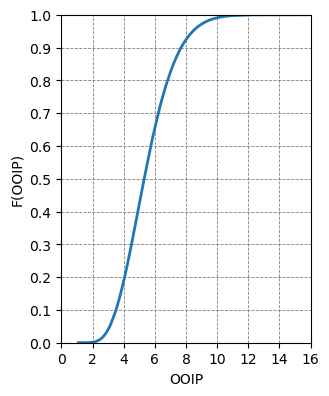

In [16]:
mpl.style.use('default')
fig, ax = plt.subplots(figsize = (4, 4.1))

ax.plot(x_popul, y_popul, linestyle = '-', linewidth = 2)
plt.xlabel('OOIP')
plt.ylabel('F(OOIP)')
plt.xlim (0, 16.05)
plt.ylim (0, 1)
ax.set_yticks (np.arange(0,1.1,0.1))
ax.set_xticks (np.arange(0,16.05,2))
ax.grid (color = 'gray', linestyle = '--', linewidth = 0.6)
#plt.margins(0.05)  # keep data off plot edges

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.45)        
plt.savefig (outdir + 'figures/figure_3.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

## Independent Five-Variate Case

### Monte Carlo Simulation (`MCS`)

#### Draw required number of seed values

100 different seed values have been used. 

In [17]:
seeds = SeedVal (datafl = 'seed.csv', colname = 'seed_nums')
print ('The seed values for the specified number of realizations are given as follows: ', seeds)

Enter the number of realizations needed: 100


Loop 1:   0%|          | 0/100 [00:00<?, ?it/s]

The seed values for the specified number of realizations are given as follows:  [87627726, 84948188, 95466538, 87485865, 95420447, 87635999, 87898184, 89260447, 90285746, 88065150, 80742041, 88032137, 86406186, 94106366, 80728413, 81886148, 88846255, 96168276, 92656830, 97247512, 83015687, 82177836, 89236783, 83827629, 95888249, 94533398, 89570295, 91429915, 93370778, 92418746, 84520326, 86734943, 97895969, 88602406, 84782223, 87871833, 85202300, 85899826, 85498982, 78978320, 94304838, 82609740, 97809106, 89748971, 93393515, 95165525, 96261586, 87880207, 90511554, 96412597, 97544868, 91693230, 90508540, 82791975, 90813626, 80335921, 94601869, 97043327, 94026257, 89815006, 83011206, 87914654, 85601060, 86068877, 81196404, 80058345, 92767479, 96439301, 96208084, 83684927, 91457878, 93867273, 84087509, 84177395, 94310268, 96853580, 80389931, 83468097, 80451784, 86980710, 85337952, 79410845, 85930416, 87987643, 79383450, 87885569, 85934013, 85168226, 82750222, 90768974, 79476154, 90722145,

#### Sampling using `MCS` sampling technique

In [18]:
def rand_sample (n, samples, nreals, seed = None):
    
    '''This function takes the random samples between
    0 and 1. The arguments of the function includes 
    n = dimension, samples = number of samples, nreals = 
    number of realizations'''
    
    u_list = []
    
    if seed == None:
        for j in range (nreals):
            u = np.random.rand (samples, n)
            u_list.append (u)
            del u
    elif isinstance (seed, list) == False:
        seed_value = seed
        np.random.seed (seed_value)
        u = np.random.rand (samples, n)
    elif isinstance (seed, list) == True:
        for j in range (nreals):
            seed_value = seed
            np.random.seed (seed_value [j])
            u = np.random.rand (samples, n)
            u_list.append (u)
            del u
    
    return u_list

#### Generate required number of realizations using `MCS`

In [19]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
mcs_samples = []

for i in tqdm_notebook (list_of_reals, total = 20, desc = 'Loop 1'):
    cc = rand_sample (n = 5, samples = i, nreals = 100, seed = seeds)
    mcs_samples.append (cc)
    del cc
    time.sleep (0.000000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Convert array to dataframe

In [20]:
dataframes = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results [i][0], results [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes.append (x)
    del x
    time.sleep (0.00000001)

g = []
for i in range (20):
    i = [[], [], [], [], []]
    g.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    for j in range (100):
        for k in range (5):
            f = np.quantile (dataframes [k] ['values'], mcs_samples [i][j].T [k])
            g[i][k].append (f)
            del f
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### Classic Latin Hypercube Sampling (`CLHS`)

#### Sampling using `CLHS` sampling technique

In [21]:
def classic_lhs (n, samples, nreals, seed = None):
    
    classic_samples = []
    
    if seed == None:
        for j in range (nreals):
            a = _lhsclassic (n, samples)
            classic_samples.append (a)
            del a
    elif isinstance (seed, list) == False:
        seed_value = seed
        np.random.seed (seed_value)
        a = _lhsclassic (n, samples)
    elif isinstance (seed, list) == True:
        for j in range (nreals):
            seed_value = seed
            np.random.seed (seed_value [j])
            a = _lhsclassic (n, samples)
            classic_samples.append (a)
            del a
   
    return classic_samples

#### Generate required number of realizations using `CLHS`

In [22]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
classic_lhs_samples = []

for i in tqdm_notebook (list_of_reals, total = 20, desc = 'Loop 1'):
    vv = classic_lhs (n = 5, samples = i, nreals = 100, seed = seeds)
    classic_lhs_samples.append (vv)
    del vv
    time.sleep (0.000000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Convert array to dataframe

In [23]:
dataframes = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results [i][0], results [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_clhs = []

for i in range (20):
    i = [[], [], [], [], []]
    g_clhs.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    for j in range (100):
        for k in range (5):
            f = np.quantile (dataframes [k] ['values'], classic_lhs_samples [i][j].T [k])
            g_clhs [i][k].append (f)
            del f
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### Maximin Latin Hypercube Sampling (`Maximin LHS`)

#### Sampling using `Maximin LHS` sampling technique

In [24]:
def maximin_lhs (n, samples, iterations, lhstype, nreals, seed = None):
    
    maximin_samples = []

    if seed == None:
        for j in range (nreals):
            a = _lhsmaximin (n, samples, iterations , lhstype)
            maximin_samples.append (a)
            del a
    
    elif isinstance (seed, list) == False:
        seed_value = seed
        np.random.seed (seed_value)
        a = _lhsmaximin (n, samples, iterations , lhstype)
   
    elif isinstance (seed, list) == True:
        for j in range (nreals):
            seed_value = seed
            np.random.seed (seed_value [j])
            a = _lhsmaximin (n, samples, iterations , lhstype)
            maximin_samples.append (a)
            del a

    return maximin_samples

#### Generate the required number of realizations using `Maximin LHS`

In [25]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
maximin_lhs_samples = []
iters = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,100, 100, 100, 10, 
         10, 10, 10, 10, 10]
reals_num = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1]

for i, j, u in tqdm_notebook (zip (list_of_reals, iters, reals_num), total = 20, desc = 'Loop 1'):
    kkk = maximin_lhs (n = 5, samples = i, iterations = j, lhstype = 'maximin', nreals = u, seed = seeds)
    maximin_lhs_samples.append (kkk)
    del kkk
    time.sleep (0.000000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Convert array to dataframe

In [26]:
dataframes = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results [i][0], results [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_maxi_lhs = []

for i in range (20):
    i = [[], [], [], [], []]
    g_maxi_lhs.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    if i >= 0 and  i < 10:
        for j in range (100):
            for k in range (5):
                f = np.quantile (dataframes [k] ['values'], maximin_lhs_samples [i][j].T [k])
                g_maxi_lhs [i][k].append (f)
                del f
    elif i > 9 and  i < 14:
        for j in range (10):
            for k in range (5):
                ff = np.quantile (dataframes [k] ['values'], maximin_lhs_samples [i][j].T [k])
                g_maxi_lhs [i][k].append (ff)
                del ff
    elif i > 13 and i < 20:
        for j in range (1):
            for k in range (5):
                ffd = np.quantile (dataframes [k] ['values'], maximin_lhs_samples [i][j].T [k])
                g_maxi_lhs [i][k].append (ffd)
                del ffd
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### Latin Hypercube Sampling with Maximum Uniformity (`LHSMDU`) 

#### Load the `LHSMDU.EXE` `GSLIB` program and its parameter file

In [27]:
lhsmdu = gs.Program (exedir + 'lhsmdu.exe', getpar = True)

C:\Users\erten\Desktop\github_ppmt_sampling\tmpy5nwrtdq\lhsmdu.par has been copied to the clipboard


#### Paste the parameter file

In [28]:
lhsmdupar = """   Parameters for LHSMDU
                  *********************

START OF PARAMETERS:
{nvar}                   - N number of variables
{nreals}                 - L number of realizations
5                        - M realization initialization factor
{seed}                   - random number generator seed
Nofile
Nofile
{output_3}
Nofile
0                        -consider correlation matrix? (0=no,1=yes)
1.000    0.000    0.000    0.000    0.000
0.000    1.000    0.000    0.000    0.000
0.000    0.000    1.000    0.000    0.000
0.000    0.000    0.000    1.000    0.000
0.000    0.000    0.000    0.000    1.000
"""

list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]

for k, l in tqdm_notebook (zip (range (100), seeds), total = 100, desc = 'Loop 1'):
    k = k + 1
    for j in range (10, 110, 10):
        lhsmdu.run (parstr = lhsmdupar.format (nvar = 5, nreals = j, seed = l,  
                                           output_3 = outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (k, j)), 
                                          liveoutput = False)
    
for k, l in tqdm_notebook (zip (range (10), seeds), total = 10, desc = 'Loop 1'):
    k = k + 1
    for j in range (200, 600, 100):
        lhsmdu.run (parstr = lhsmdupar.format (nvar = 5, nreals = j, seed = l,  
                                           output_3 = outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (k, j)), 
                                          liveoutput = False)
    
for k, l in tqdm_notebook (zip (range (1), seeds), total = 1, desc = 'Loop 1'):
    k = k + 1
    for j in range (1000, 11000, 2000):
        lhsmdu.run (parstr = lhsmdupar.format (nvar = 5, nreals = j, seed = l,  
                                           output_3 = outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (k, j)), 
                                          liveoutput = False)

for k, l in tqdm_notebook (zip (range (1), seeds), total = 1, desc = 'Loop 1'):
    k = k + 1
    for j in range (10000, 11000, 1000):
        lhsmdu.run (parstr = lhsmdupar.format (nvar = 5, nreals = j, seed = l,  
                                           output_3 = outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (k, j)), 
                                          liveoutput = False)
        time.sleep (0.00000001)

Loop 1:   0%|          | 0/100 [00:00<?, ?it/s]

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['

Loop 1:   0%|          | 0/10 [00:00<?, ?it/s]

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['

Loop 1:   0%|          | 0/1 [00:00<?, ?it/s]

Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']
Calling:  ['exes/lhsmdu.exe', 'temp']


Loop 1:   0%|          | 0/1 [00:00<?, ?it/s]

Calling:  ['exes/lhsmdu.exe', 'temp']


#### Load the samples generated by `LHSMDU.EXE` `GSLIB` program

In [29]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
lhsmdu_samp_1 = []

for i in tqdm_notebook (list_of_reals [0:10] , total = 10, desc = 'Loop 1'):
    for j in range (100):
        j = j + 1
        c = gs.DataFile (outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (j, i))
        lhsmdu_samp_1.append (c)
        del c
        time.sleep (0.00000001)
        
lhsmdu_samp_2 = []

for i in tqdm_notebook (list_of_reals[10:14], total = 4, desc = 'Loop 2'):
    for j in range (10):
        j = j + 1
        b = gs.DataFile (outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (j, i))
        lhsmdu_samp_2.append (b)
        del b
        time.sleep (0.00000001)
        
lhsmdu_samp_3 = []

for i in tqdm_notebook (list_of_reals[14:20], total = 6, desc = 'Loop 3'):
    for j in range (1):
        j = j + 1
        bb = gs.DataFile (outdir + 'lhsmdu/lhsmdu_{}_{}.out'.format (j, i))
        lhsmdu_samp_3.append (bb)
        del bb
        time.sleep (0.00000001)

Loop 1:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/6 [00:00<?, ?it/s]

#### Convert the dataframe to array

In [30]:
lhsmdu_array_1 = []

for j in range (1000):
    f = lhsmdu_samp_1 [j].data.to_numpy ()
    lhsmdu_array_1.append (f)
    del f

lhsmdu_array_2 = []

for j in range (40):
    d = lhsmdu_samp_2 [j].data.to_numpy ()
    lhsmdu_array_2.append (d)
    del d

lhsmdu_array_3 = []

for j in range (6):
    dp = lhsmdu_samp_3 [j].data.to_numpy ()
    lhsmdu_array_3.append (dp)
    del dp
    
first_array = [lhsmdu_array_1 [0:100], lhsmdu_array_1 [100:200], lhsmdu_array_1 [200:300], lhsmdu_array_1 [300:400], 
lhsmdu_array_1 [400:500], lhsmdu_array_1 [500:600], lhsmdu_array_1 [600:700], lhsmdu_array_1 [700:800], 
lhsmdu_array_1 [800:900], lhsmdu_array_1 [900:1000], lhsmdu_array_2 [0:10], lhsmdu_array_2 [10:20], 
              lhsmdu_array_2 [20:30], lhsmdu_array_2 [30:40], lhsmdu_array_3 [0:1], lhsmdu_array_3 [1:2],
              lhsmdu_array_3 [2:3], lhsmdu_array_3 [3:4], lhsmdu_array_3 [4:5], lhsmdu_array_3 [5:6]]

#### Convert array to dataframe

In [31]:
dataframes = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results [i][0], results [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_mdu_lhs = []

for i in range (20):
    i = [[], [], [], [], []]
    g_mdu_lhs.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    if i >= 0 and  i < 10:
        for j in range (100):
            for k in range (5):
                f = np.quantile (dataframes [k] ['values'], first_array [i][j].T [k])
                g_mdu_lhs [i][k].append (f)
                del f
    elif i > 9 and  i < 14:
        for j in range (10):
            for k in range (5):
                ff = np.quantile (dataframes [k] ['values'], first_array [i][j].T [k])
                g_mdu_lhs [i][k].append (ff)
                del ff
    elif i > 13 and i < 20:
        for j in range (1):
            for k in range (5):
                ffd = np.quantile (dataframes [k] ['values'], first_array [i][j].T [k])
                g_mdu_lhs [i][k].append (ffd)
                del ffd
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### Projection Pursuit Multivariate Transform (`PPMT`) 

#### Sampling using `MCS` sampling technique

In [32]:
def rand_sample (n, samples, nreals, seed = None):
    
    '''This function takes the random samples between
    0 and 1. The arguments of the function includes 
    n = dimension, samples = number of samples, nreals = 
    number of realizations'''
    
    u_list = []
    
    if seed == None:
        for j in range (nreals):
            u = np.random.rand (samples, n)
            u_list.append (u)
            del u
    elif isinstance (seed, list) == False:
        seed_value = seed
        np.random.seed (seed_value)
        u = np.random.rand (samples, n)
    elif isinstance (seed, list) == True:
        for j in range (nreals):
            seed_value = seed
            np.random.seed (seed_value [j])
            u = np.random.rand (samples, n)
            u_list.append (u)
            del u

    return u_list

#### Generate required number of realizations using `MCS`

In [33]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
ppmt_samples = []


for j in tqdm_notebook (list_of_reals [0:17], total = 17, desc = 'Loop 1'):
    cc = rand_sample (n = 5, samples = j, nreals = 100, seed = seeds)
    ppmt_samples.append (cc)
    del cc
    time.sleep (0.000000000001)

for j in tqdm_notebook (list_of_reals [17:20],  total = 3, desc = 'Loop 2'):
        ccc = rand_sample (n = 5, samples = j, nreals = 10, seed = seeds)
        ppmt_samples.append (ccc)
        del ccc
        time.sleep (0.000000000001)

Loop 1:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

#### Function for calculating the inverse CDF

In [34]:
columns = []
for j in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    j = j + 1
    x = 'var{}'.format (j)
    columns.append (x)
    del x
    time.sleep (0.00001)
columns

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

['var1', 'var2', 'var3', 'var4', 'var5']

#### Calculate the inverse CDF of the realizations

In [35]:
ppmt_input_inv_cdf = []

for i in range (20):
    i = []
    ppmt_input_inv_cdf.append (i)
    
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]

for i in tqdm_notebook (range (0, 17, 1), total = 17, desc = 'Loop 1'):
    for j in range (100):
        a = stats.norm.ppf (ppmt_samples [i][j])
        ppmt_input_inv_cdf [i].append (a)
        del a
        time.sleep (0.000001)
        

for i in tqdm_notebook (range (17, 20, 1), total = 3, desc = 'Loop 2'):
    for j in range (10):
        b = stats.norm.ppf (ppmt_samples [i][j])
        ppmt_input_inv_cdf [i].append (b)
        del b
        time.sleep (0.000001)


for i, k in tqdm_notebook (zip (range (20), list_of_reals) , total = 20, desc = 'Loop 3'):
    if i >=0 and i < 17:
        for j, h in zip (range (100), range (100)):
            h = h + 1
            d = pd.DataFrame (ppmt_input_inv_cdf [i][j], columns = columns)
            gs.write_gslib (d, outdir + 'ppmt/datafl_{}_{}.out'.format (h, k))
            del d
    elif i >=17 and i < 20:
        for j, h in zip (range (10), range (10)):
            h = h + 1
            dd = pd.DataFrame (ppmt_input_inv_cdf [i][j], columns = columns)
            gs.write_gslib (dd, outdir + 'ppmt/datafl_{}_{}.out'.format (h, k))
            del dd
            time.sleep (0.000001)
        

Loop 1:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/20 [00:00<?, ?it/s]

#### Load the `PPMT.EXE` `GSLIB` program and its parameter file

In [36]:
ppmt = gs.Program (program = exedir + 'ppmt.exe', getpar = True)

C:\Users\erten\Desktop\github_ppmt_sampling\tmpu2jsaed1\ppmt.par has been copied to the clipboard


#### Paste the parameter file

In [37]:
ppmtparf = """             Parameters for PPMT
                         *******************
START OF PARAMETERS:
{datafl}                 - input data file
5 1 2 3 4 5 0            - number of variables, variable cols, and wt col
-1.0e7 1.0e7             - trimming limits
25 50 50                 - min/max iterations and targeted Gauss perc. (see Note 1)
0                        - spatial decorrelation? (0=no,1=yes) (see Note 2)
0 0 0                    - x, y, z columns (0=none for z)
0 0                      - lag distance, lag tolerance
{output_1}               - output data file
Nofilr                   - output transformation table (binary)

Note 1: Optional stopping criteria, where the projection pursuit algorithm will terminate
after reaching the targetted Gaussian percentile. The input percentile range is 1 (very Gaussian)
to 99 (barely Gaussian); the percentiles are calculated using random Gaussian distributions.
The min/max iterations overrides the targetted Gaussian percentile.

Note 2: Option to apply min/max autocorrelation factors after the projection pursuit algorithm
to decorrelate the variables at the specified non-zero lag distance.
"""

list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]

for j in tqdm_notebook (range (100), total = 100, desc = 'Loop 1'):
    j = j + 1
    for i in list_of_reals [0: 17]:
        ppmt.run (parstr = ppmtparf.format (datafl = outdir + 'ppmt/datafl_{}_{}.out'.format (j, i)
                                        , output_1 = outdir + 'ppmt/ppmt_1/ppmt_{}_{}.out'.format (j, i)),
                                            liveoutput = False)
        time.sleep (0.000001)
        
for j in tqdm_notebook (range (10), total = 10, desc = 'Loop 2'):
    j = j + 1
    for i in list_of_reals [17:20]:
        ppmt.run (parstr = ppmtparf.format (datafl = outdir + 'ppmt/datafl_{}_{}.out'.format (j, i)
                                        , output_1 = outdir + 'ppmt/ppmt_1/ppmt_{}_{}.out'.format (j, i)), 
                                            liveoutput = False)
        time.sleep (0.000001)
        

Loop 1:   0%|          | 0/100 [00:00<?, ?it/s]

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

Loop 2:   0%|          | 0/10 [00:00<?, ?it/s]

Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 'temp']
Calling:  ['exes/ppmt.exe', 

#### Load the PPMT scores

In [38]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
ppmt_samp = []

for i in range (20):
    i = []
    ppmt_samp.append (i)

for i, j in tqdm_notebook (zip (list_of_reals [0:17], range (17)), total = 17, desc = 'Loop 1'):
    for k in range (100):
        k = k + 1
        a = gs.DataFile (outdir + 'ppmt/ppmt_1/ppmt_{}_{}.out'.format (k, i), readfl = True)
        if a.data.isnull().values.any() == True:
            print (i, j, k)
        ppmt_samp [j].append (a)
        del a
        time.sleep (0.00000000001)
        
for i, j in tqdm_notebook (zip (list_of_reals [17:20], range (17, 20, 1)), total = 3, desc = 'Loop 2'):
    for k in range (10):
        k = k + 1
        a = gs.DataFile (outdir + 'ppmt/ppmt_1/ppmt_{}_{}.out'.format (k, i), readfl = True)
        if a.data.isnull().values.any() == True:
            print (i, j, k)
        ppmt_samp [j].append (a)
        del a
        time.sleep (0.00000000001)

Loop 1:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

#### Back-transfrom the PPMT scores to the unifrom distribution

In [39]:
ppmt_trans = []

for i in range (20):
    i = []
    ppmt_trans.append (i)

for i in tqdm_notebook (range (17) , total = 17, desc = 'Loop 1'):
    for j in range (100):
        for k in range (5):
            k = k + 1
            ppmt = stats.norm.cdf (ppmt_samp [i][j].data ['PPMT:var{}'.format (k)])
            ppmt_trans [i].append (ppmt)
            del ppmt
            time.sleep (0.0000000001)
            
for i in tqdm_notebook (range (17, 20, 1) , total = 3, desc = 'Loop 2'):
    for j in range (10):
        for k in range (5):
            k = k + 1
            ppmt = stats.norm.cdf (ppmt_samp [i][j].data ['PPMT:var{}'.format (k)])
            ppmt_trans [i].append (ppmt)
            del ppmt
            time.sleep (0.0000000001)

Loop 1:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

#### Combine all of the back-transformed PPMT scores

In [40]:
stacked = []

for i in range (20):
    i = []
    stacked.append (i)

for i in tqdm_notebook (range (17), total = 17, desc = 'Loop 1'):
    for j, k  in zip (range (0, 500, 5), range (5, 505, 5)):
        a = np.stack (ppmt_trans  [i][j:k], axis = 1)
        stacked [i].append (a) 
        del a
        time.sleep (0.000000001)
        
for i in tqdm_notebook (range (17, 20, 1), total = 3, desc = 'Loop 2'):
    for j, k  in zip (range (0, 50, 5), range (5, 55, 5)):
        a = np.stack (ppmt_trans  [i][j:k], axis = 1)
        stacked [i].append (a) 
        del a
        time.sleep (0.000000001)
        
ppmt_s = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 3'):
    s = stacked [i]
    ppmt_s.append (s)
    del s
    time.sleep (0.000000001)

Loop 1:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/20 [00:00<?, ?it/s]

#### Convert array to dataframe

In [41]:
dataframes = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results [i][0], results [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes.append (x)
    del x
    time.sleep (0.00000001)

g_ppmt_reals = []
for i in range (20):
    i = [[], [], [], [], []]
    g_ppmt_reals.append (i)

for i in tqdm_notebook (range (17), total = 17, desc = 'Loop 2'):
        for j in range (100):
            for k in range (5):
                f = np.quantile (dataframes [k] ['values'], ppmt_s [i][j].T [k])
                g_ppmt_reals [i][k].append (f)
                del f
                time.sleep (0.00000001)
        
for i in tqdm_notebook (range (17, 20, 1), total = 3, desc = 'Loop 3'):
        for j in range (10):
            for k in range (5):
                f = np.quantile (dataframes [k] ['values'], ppmt_s [i][j].T [k])
                g_ppmt_reals [i][k].append (f)
                del f
                time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/3 [00:00<?, ?it/s]

### Correlated 5-variate case

Now, we consider that the five variables are linearly correlated with one another. The strength of the correlation between variables is given by the following matrix $\textrm{A}$:

\begin{equation*}
\textbf{A} =  \begin{bmatrix} 
 1 & 0 & 0 & 0 & 0 \\
 0 & 1 & 0.3 & 0.25 & -0.4  \\
 0 & 0.3 & 1 & 0.4 & -0.5 \\
 0 & 0.25 & 0.4 & 1 & -0.6 \\
 0 & -0.4 & -0.5 & -0.6 & 1
\end{bmatrix}_{ 5\times 5}  
\end{equation*}

#### Create a dataframe containing the underlying OOIP variables

In [42]:
a = zip (area, thick, net_oil, net_poros, water_sat)
population_data = pd.DataFrame (a, columns = ['Area', 'Thickness', 'Net oil to gross volume', 'Net porosity', 
                                              'Water saturation'])
population_data.head ()

Area  Thickness  Net oil to gross volume  Net porosity  \
0  3.730988   9.814180                 0.757733      0.254418   
1  5.372078  10.674325                 0.672235      0.282318   
2  4.535743  10.356546                 0.677443      0.265971   
3  4.208148  10.506541                 0.695290      0.244715   
4  3.117206   9.679240                 0.662315      0.162740   

   Water saturation  
0          0.180966  
1          0.292744  
2          0.208224  
3          0.204836  
4          0.190441

#### Display the scatter plots of the independent populations (Area, Thickness, Net oil to gross| volume, Net porosity, Water saturation) 

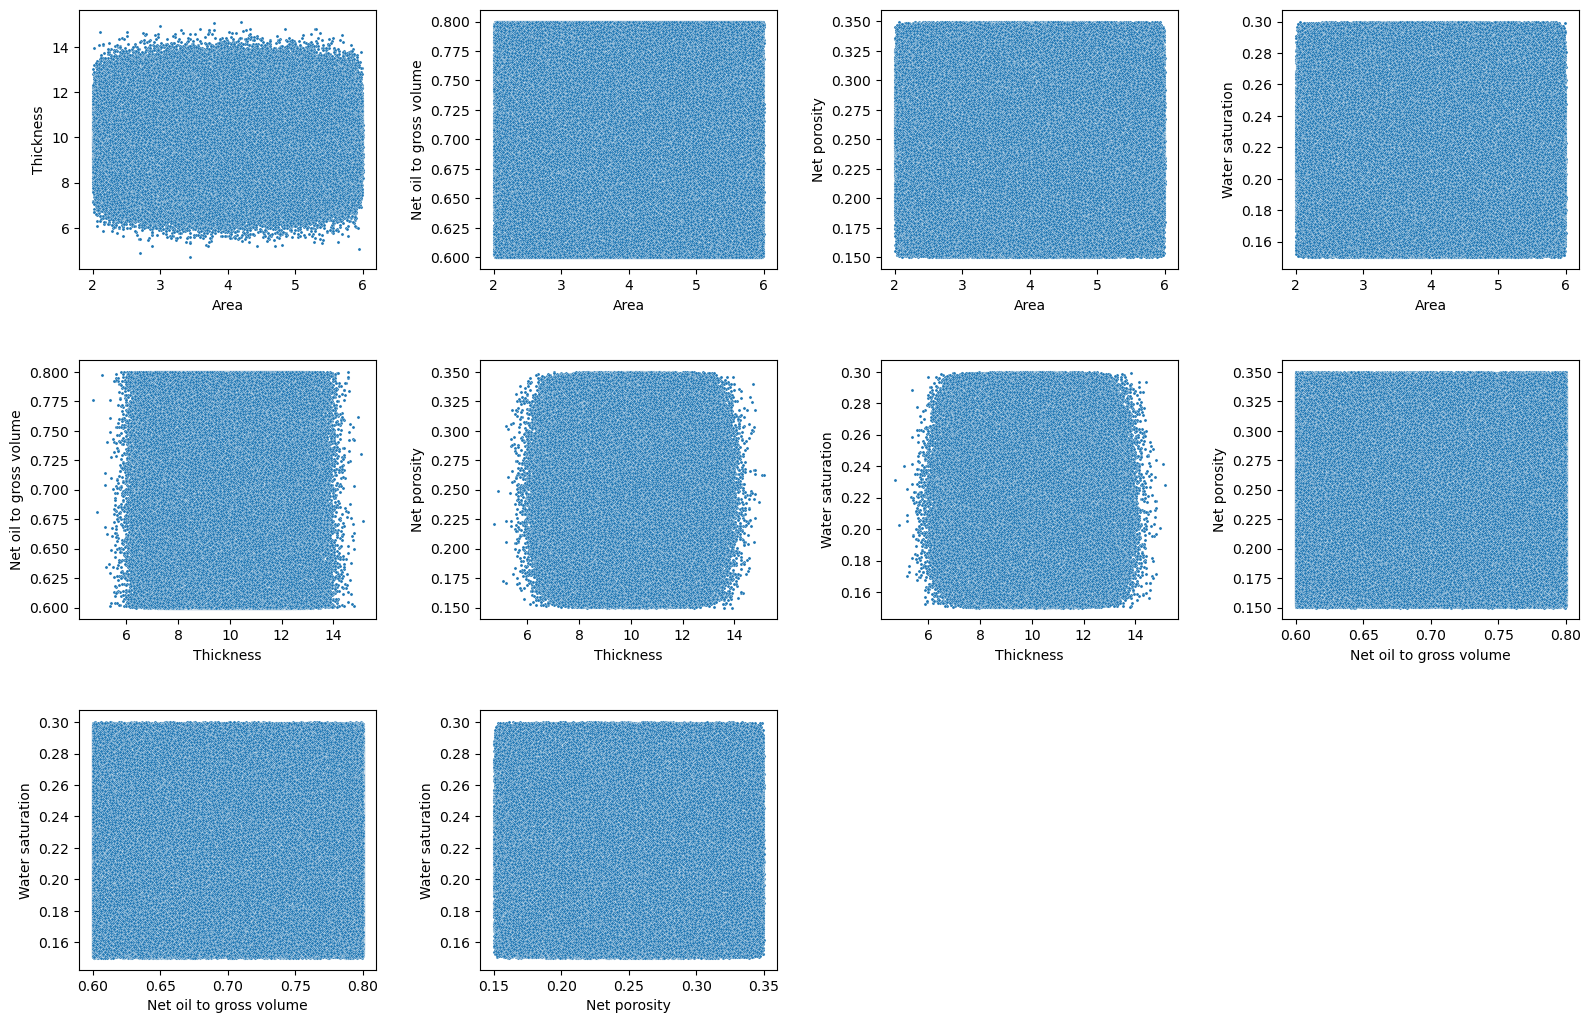

In [43]:
mpl.style.use('default')

plt.figure (figsize = (24, 12))
plt.subplot (3, 4, 1)
g = sns.scatterplot (x = f'Area', y = f'Thickness', data = population_data, s = 5)

plt.subplot (3, 4, 2)
g = sns.scatterplot (x = f'Area', y = f'Net oil to gross volume', data = population_data, s = 5)

plt.subplot (3, 4, 3)
g = sns.scatterplot (x = f'Area', y = f'Net porosity', data = population_data, s = 5)

plt.subplot (3, 4, 4)
g = sns.scatterplot (x = f'Area', y = f'Water saturation', data = population_data, s = 5)

plt.subplot (3, 4, 5)
g = sns.scatterplot (x = f'Thickness', y = f'Net oil to gross volume', data = population_data, s = 5)

plt.subplot (3, 4, 6)
g = sns.scatterplot (x = f'Thickness', y = f'Net porosity', data = population_data, s = 5)

plt.subplot (3, 4, 7)
g = sns.scatterplot (x = f'Thickness', y = f'Water saturation', data = population_data, s = 5)

plt.subplot (3, 4, 8)
g = sns.scatterplot (x = f'Net oil to gross volume', y = f'Net porosity', data = population_data, s = 5)

plt.subplot (3, 4, 9)
g = sns.scatterplot (x = f'Net oil to gross volume', y = f'Water saturation', data = population_data, s = 5)

plt.subplot (3, 4, 10)
g = sns.scatterplot (x = f'Net porosity', y = f'Water saturation', data = population_data, s = 5)

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.35)
plt.savefig (outdir + 'figures/figure_4.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Create the target correlation matrix

In [44]:
variance = [1, 1, 1, 1, 1]
corre = [0, 0, 0, 0, 0.3, 0.25, -0.4, 0.4, -0.5, -0.6]
cov_matrix_fvar = cov_mat (var = variance, corr = corre)

 
The covariance matrix for the given inputs is as follows:
 


array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.3 ,  0.25, -0.4 ],
       [ 0.  ,  0.3 ,  1.  ,  0.4 , -0.5 ],
       [ 0.  ,  0.25,  0.4 ,  1.  , -0.6 ],
       [ 0.  , -0.4 , -0.5 , -0.6 ,  1.  ]])

### Cholesky Decomposition 
#### Compute the lower triangular matrix of the covariance matrix

In [45]:
l_matrix_ = scipy.linalg.cholesky (cov_matrix_fvar, lower = True)
pprint.pprint (l_matrix_)

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.3       ,  0.9539392 ,  0.        ,  0.        ],
       [ 0.        ,  0.25      ,  0.34069257,  0.90632697,  0.        ],
       [ 0.        , -0.4       , -0.39834824, -0.40193631,  0.72094791]])


#### Calculate the upper triangular matrix of the covariance matrix

In [46]:
u_matrix_ = scipy.linalg.cholesky (cov_matrix_fvar, lower = False)
pprint.pprint (u_matrix_)

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.3       ,  0.25      , -0.4       ],
       [ 0.        ,  0.        ,  0.9539392 ,  0.34069257, -0.39834824],
       [ 0.        ,  0.        ,  0.        ,  0.90632697, -0.40193631],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.72094791]])


#### Make the underlying variables correlated 

#### Draw the required number of seed values

1 seed value is required. 

In [47]:
seeds = SeedVal (datafl = 'seed.csv', colname = 'seed_nums')
print ('The seed values for the specified number of realizations are given as follows: ', seeds)

Enter the number of realizations needed: 1


Loop 1:   0%|          | 0/1 [00:00<?, ?it/s]

The seed values for the specified number of realizations are given as follows:  [87627726]


#### Sampling using `MCS` sampling technique

In [48]:
def rand_sample (n, samples, nreals, seed = None):
    
    '''This function takes the random samples between
    0 and 1. The arguments of the function includes 
    n = dimension, samples = number of samples, nreals = 
    number of realizations'''
    
    u_list = []
    
    if seed == None:
        for j in range (nreals):
            u = np.random.rand (samples, n)
            u_list.append (u)
            del u
    elif isinstance (seed, list) == False:
        seed_value = seed
        np.random.seed (seed_value)
        u = np.random.rand (samples, n)
    elif isinstance (seed, list) == True:
        for j in range (nreals):
            seed_value = seed
            np.random.seed (seed_value [j])
            u = np.random.rand (samples, n)
            u_list.append (u)
            del u
    
    return u_list

#### Generate the required number of realizations

In [49]:
pp = rand_sample (n = 5, samples = 10000000, nreals = 1, seed = seeds)
pp

[array([[0.62265247, 0.26313513, 0.90930721, 0.65678361, 0.33370034],
        [0.71637272, 0.42373773, 0.79005802, 0.85651135, 0.72619065],
        [0.53588237, 0.5463701 , 0.81858155, 0.11503604, 0.45964256],
        ...,
        [0.56773602, 0.6998363 , 0.58090208, 0.66526707, 0.66752965],
        [0.44051924, 0.67630269, 0.64400055, 0.53083304, 0.98966347],
        [0.99313155, 0.42538842, 0.65835979, 0.56032009, 0.6999642 ]])]

#### Calculate the Gaussian deviates

In [50]:
pp_inv = stats.norm.ppf (pp)
pp_inv [0]

array([[ 0.3124546 , -0.63370975,  1.33650098,  0.40370075, -0.42971815],
       [ 0.57209952, -0.19234055,  0.80662257,  1.06477601,  0.60133226],
       [ 0.09006539,  0.11649557,  0.90997273, -1.20017322, -0.10133426],
       ...,
       [ 0.17061314,  0.52392975,  0.20420176,  0.42688119,  0.43310195],
       [-0.14965289,  0.45738461,  0.36917285,  0.07736408,  2.31390283],
       [ 2.46407072, -0.18812732,  0.40799082,  0.15178081,  0.52429756]])

#### Make the underlying variables correlated by multiplying L matrix

In [51]:
popul_corr_gaus = np.matmul (l_matrix_, pp_inv [0].T)
popul_corr_gaus 

array([[ 3.12454597e-01,  5.72099519e-01,  9.00653902e-02, ...,
         1.70613137e-01, -1.49652888e-01,  2.46407072e+00],
       [-6.33709750e-01, -1.92340548e-01,  1.16495567e-01, ...,
         5.23929754e-01,  4.57384612e-01, -1.88127317e-01],
       [ 1.08482775e+00,  7.11766722e-01,  9.03007331e-01, ...,
         3.51974988e-01,  4.89383835e-01,  3.32760245e-01],
       [ 6.62793398e-01,  1.19176039e+00, -7.48604508e-01, ...,
         5.87446399e-01,  3.10237751e-01,  2.29530652e-01],
       [-7.50975305e-01, -2.38823360e-01,  2.52203529e-04, ...,
        -1.50250416e-01,  1.30709477e+00,  2.29713511e-01]])

#### Back-transfrom the realizations to unifrom distribution 

In [52]:
popul_corr_quan = stats.norm.cdf (popul_corr_gaus )
popul_corr_quan [0]

array([0.62265247, 0.71637272, 0.53588237, ..., 0.56773602, 0.44051924,
       0.99313155])

#### Construct the underlying correlated variables by reading the quantiles

In [53]:
popul_core = []

for i, j in tqdm_notebook (zip (range (5), range (5)), total = 5, desc = 'Loop 1'):
    gg = np.quantile (dataframes [i] ['values'], popul_corr_quan [j])
    popul_core.append (gg)
    time.sleep (0.00000000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

#### Create a dataframe containing the underlying correlated variables

In [54]:
ss = zip (popul_core [0], popul_core [1], popul_core [2], popul_core [3], popul_core [4])
population_data_core = pd.DataFrame (ss, columns = ['Area', 'Thickness', 'Net oil to gross volume', 'Net porosity', 
                                              'Water saturation'])
population_data_core.head ()

Area  Thickness  Net oil to gross volume  Net porosity  \
0  4.262607   9.366293                 0.772151      0.278757   
1  4.493586   9.808315                 0.752262      0.301692   
2  4.073122  10.116970                 0.763281      0.217402   
3  3.777918   8.719212                 0.729209      0.245070   
4  4.365328  10.736226                 0.734214      0.247357   

   Water saturation  
0          0.191181  
1          0.205571  
2          0.213395  
3          0.226235  
4          0.193096

#### Plot the CDF of the underlying correlated variables

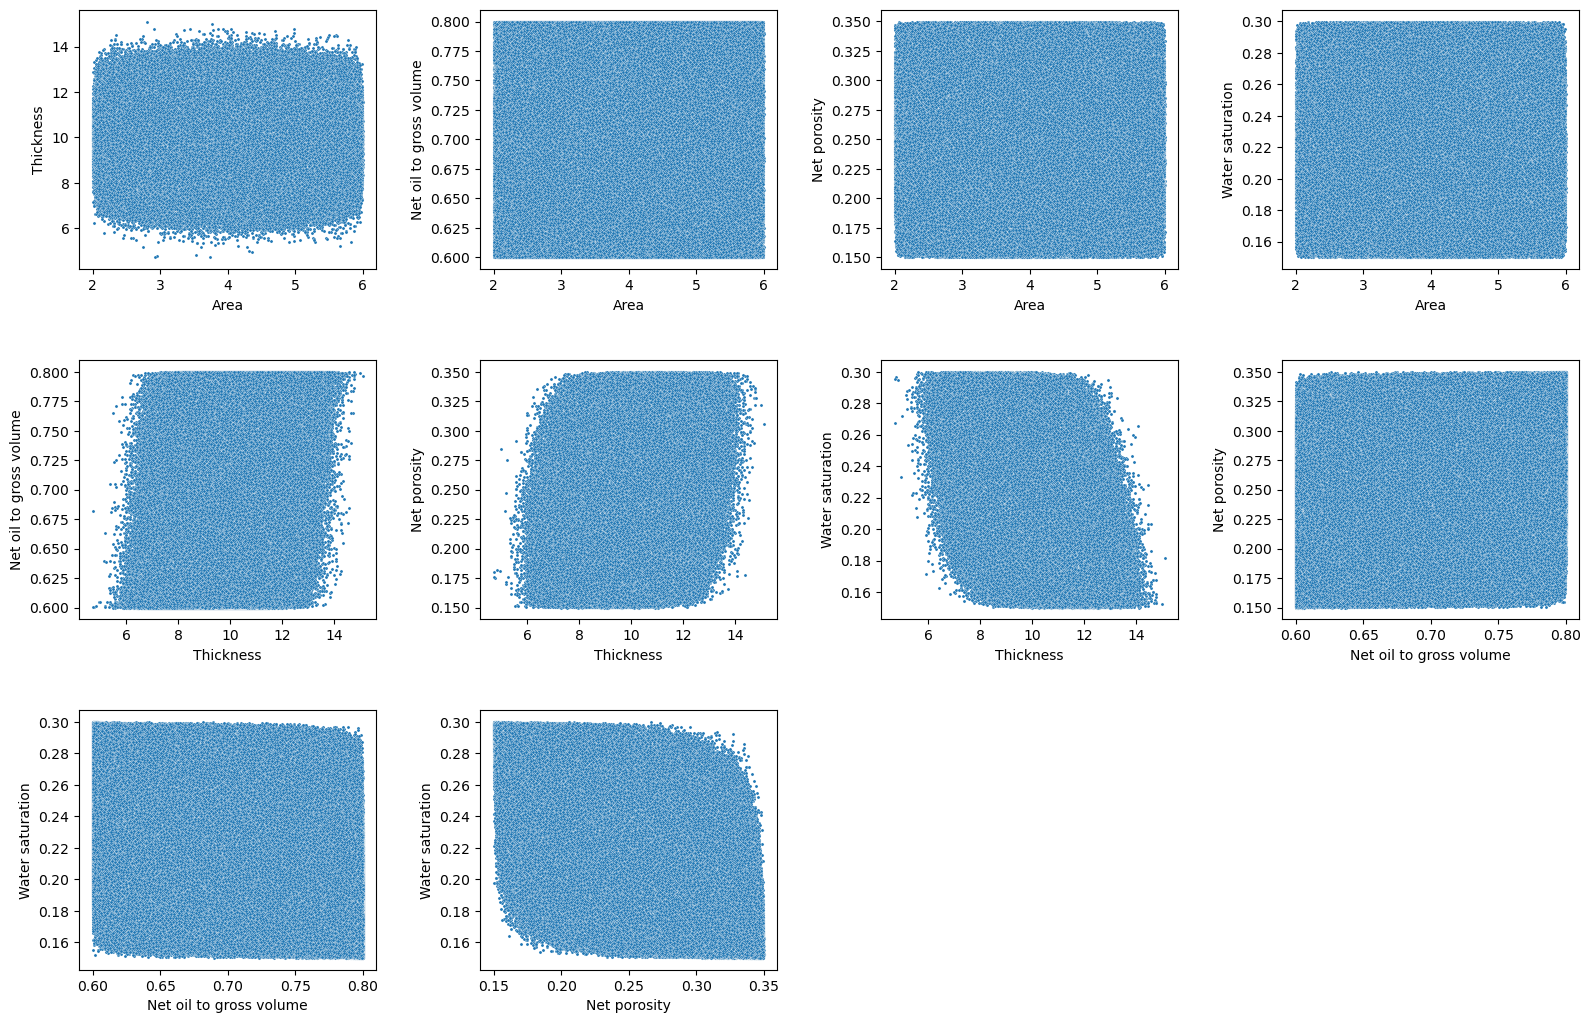

In [55]:
mpl.style.use('default')

plt.figure (figsize = (24, 12))
plt.subplot (3, 4, 1)
g = sns.scatterplot (x = f'Area', y = f'Thickness', data = population_data_core, s = 5)

plt.subplot (3, 4, 2)
g = sns.scatterplot (x = f'Area', y = f'Net oil to gross volume', data = population_data_core, s = 5)

plt.subplot (3, 4, 3)
g = sns.scatterplot (x = f'Area', y = f'Net porosity', data = population_data_core, s = 5)

plt.subplot (3, 4, 4)
g = sns.scatterplot (x = f'Area', y = f'Water saturation', data = population_data_core, s = 5)

plt.subplot (3, 4, 5)
g = sns.scatterplot (x = f'Thickness', y = f'Net oil to gross volume', data = population_data_core, s = 5)

plt.subplot (3, 4, 6)
g = sns.scatterplot (x = f'Thickness', y = f'Net porosity', data = population_data_core, s = 5)

plt.subplot (3, 4, 7)
g = sns.scatterplot (x = f'Thickness', y = f'Water saturation', data = population_data_core, s = 5)

plt.subplot (3, 4, 8)
g = sns.scatterplot (x = f'Net oil to gross volume', y = f'Net porosity', data = population_data_core, s = 5)

plt.subplot (3, 4, 9)
g = sns.scatterplot (x = f'Net oil to gross volume', y = f'Water saturation', data = population_data_core, s = 5)

plt.subplot (3, 4, 10)
g = sns.scatterplot (x = f'Net porosity', y = f'Water saturation', data = population_data_core, s = 5)

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.35)
plt.savefig (outdir + 'figures/figure_5.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Function for calculating the empirical cumulative distribution function

In [56]:
def ecdf(data):
    
    """Compute ECDF for a one-dimensional 
    array of measurements."""
    
    n = len (data)
    x = np.sort (data)
    y = np.arange (1, n + 1) / n

    return x, y

#### Calculate the cumulative distribution functions of the five variables of OOIP

In [57]:
popul_array_core = population_data_core.to_numpy ()
popul_array_core.T [0]

array([4.26260715, 4.49358642, 4.07312151, ..., 4.14049433, 3.87748947,
       5.76546001])

#### Save the quantiles and their corresponding values to a list

In [58]:
results_core = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    kk = ecdf (popul_array_core.T [i])
    results_core.append (kk)
    del kk
    time.sleep (0.0000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

#### Plot the empirical cumulative distribution functions of the five variables of OOIP

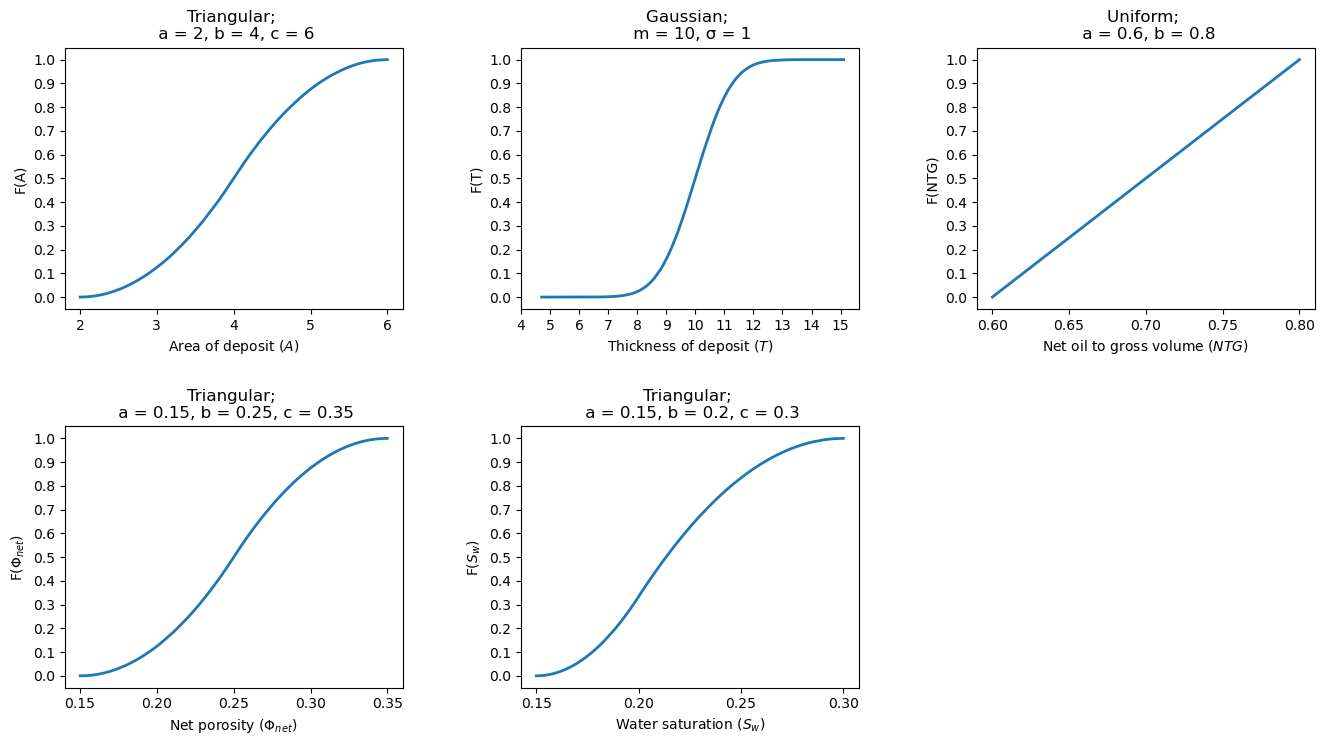

In [59]:
mpl.style.use('default')
fig, axes = plt.subplots(2, 3, figsize = (20, 8)) 

axes [0, 0].plot (results_core [0][0], results_core [0][1], linestyle = '-', linewidth = 2)
axes[0, 0].set (xlabel = 'Area of deposit ($A$)', ylabel = 'F(A)')
axes[0, 0].set_title ('Triangular; \n a = 2, b = 4, c = 6')
plt.xlim (2, 6)
plt.ylim (-0.02, 1.02)
axes [0, 0].set_yticks (np.arange(0,1.1,0.1))
axes [0, 0].set_xticks (np.arange(2,7,1))

axes [0, 1].plot (results_core [1][0], results_core [1][1], linestyle = '-', linewidth = 2)
axes [0, 1].set (xlabel = 'Thickness of deposit ($T$)', ylabel = 'F(T)')
axes[0, 1].set_title ('Gaussian; \n m = 10, \u03C3 = 1')
plt.xlim (4, 15)
plt.ylim (-0.02, 1.02)
axes [0, 1].set_yticks (np.arange(0,1.1,0.1))
axes [0, 1].set_xticks (np.arange(4,16,1))

axes [0, 2].plot (results_core [2][0], results_core [2][1], linestyle = '-', linewidth = 2)
axes [0, 2].set (xlabel = 'Net oil to gross volume ($NTG$)', ylabel = 'F(NTG)')
axes[0, 2].set_title ('Uniform; \n a = 0.6, b = 0.8')
plt.xlim (0.6, 0.85)
plt.ylim (-0.02, 1.02)
axes [0, 2].set_yticks (np.arange(0,1.1,0.1))
axes [0, 2].set_xticks (np.arange(0.6,0.85,0.05))

axes [1, 0].plot (results_core [3][0], results_core [3][1], linestyle = '-', linewidth = 2)
axes[1, 0].set (xlabel = 'Net porosity (\u03A6'+'$_{net}$)', ylabel = 'F(\u03A6'+'$_{net}$)')
axes[1, 0].set_title ('Triangular; \n a = 0.15, b = 0.25, c = 0.35')
plt.xlim (0.15, 0.4)
plt.ylim (-0.02, 1.02)
axes [1, 0].set_yticks (np.arange(0,1.1,0.1))
axes [1, 0].set_xticks (np.arange(0.15,0.4,0.05))


axes [1, 1].plot (results_core [4][0], results_core [4][1], linestyle = '-', linewidth = 2)
axes[1, 1].set (xlabel = 'Water saturation '+ '($S_{w}$)', ylabel = 'F($S_{w}$)')
axes[1, 1].set_title ('Triangular; \n a = 0.15, b = 0.2, c = 0.3')
plt.xlim (0.15, 0.35)
plt.ylim (-0.02, 1.02)
axes [1, 1].set_yticks (np.arange(0,1.1,0.1))
axes [1, 1].set_xticks (np.arange(0.15,0.35,0.05))

fig.delaxes (axes[1][2])

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.45)        
plt.savefig (outdir + 'figures/figure_6.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Generate the OOIP population (underlying) distribution based on the equation

In [60]:
constant = 1
ooip_core = constant * population_data_core ['Area'] * population_data_core ['Thickness'] * population_data_core ['Net oil to gross volume'] * (population_data_core ['Net porosity'] * (1 - population_data_core ['Water saturation']))
ooip_core

0          6.950607
1          7.946482
2          5.378772
3          4.554929
4          6.868123
             ...   
9999995    6.660223
9999996    7.455378
9999997    6.910102
9999998    5.804283
9999999    8.297556
Length: 10000000, dtype: float64

#### Calculate the empirical cumulative distirbution function of OOIP

In [61]:
x_popul_core, y_popul_core = ecdf (ooip_core)

#### Plot the empirical cumulative distribution function of the population (underlying) OOIP

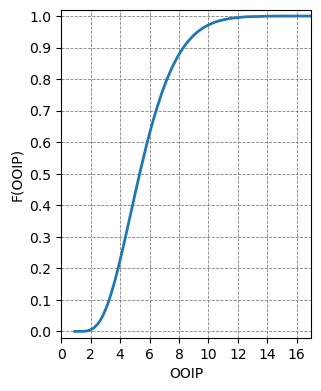

In [62]:
mpl.style.use('default')
fig, ax = plt.subplots(figsize = (4, 4.1))

ax.plot(x_popul_core, y_popul_core, linestyle = '-', linewidth = 2)
plt.xlabel('OOIP')
plt.ylabel('F(OOIP)')
plt.xlim (0, 17)
plt.ylim (-0.02, 1.02)
ax.set_yticks (np.arange(0,1.1,0.1))
ax.set_xticks (np.arange(0,17,2))
ax.grid (color = 'gray', linestyle = '--', linewidth = 0.6)
# plt.margins(0.02)  # keep data off plot edges

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.45)        
plt.savefig (outdir + 'figures/figure_7.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Compute the inverse CDF of the realizations generated by each technique

In [63]:
inv_mcs = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    a = stats.norm.ppf (mcs_samples [i])
    inv_mcs.append (a)
    del a
    time.sleep (0.00000001)
    

inv_clhs = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    a = stats.norm.ppf (classic_lhs_samples [i])
    inv_clhs.append (a)
    del a
    time.sleep (0.00000001)
    
inv_maximin = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 3'):
    a = stats.norm.ppf (maximin_lhs_samples [i])
    inv_maximin.append (a)
    del a
    time.sleep (0.00000001)
    
inv_lhsmdu = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 4'):
    a = stats.norm.ppf (first_array [i])
    inv_lhsmdu.append (a)
    del a
    time.sleep (0.00000001)
    
inv_ppmt = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 5'):
    a = stats.norm.ppf (ppmt_s [i])
    inv_ppmt.append (a)
    del a
    time.sleep (0.00000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 4:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 5:   0%|          | 0/20 [00:00<?, ?it/s]

#### Make the samples correlated by multiplying L matrix

In [64]:
mcs_corr = []
for i in range (20):
    i = []
    mcs_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for j in range (100):
        a = np.matmul (l_matrix_, inv_mcs [i][j].T)
        mcs_corr [i].append (a)
        time.sleep (0.0000000001)
        
clhs_corr = []
for i in range (20):
    i = []
    clhs_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    for j in range (100):
        a = np.matmul (l_matrix_, inv_clhs [i][j].T)
        clhs_corr [i].append (a)
        time.sleep (0.0000000001)
        
maximin_corr = []
for i in range (20):
    i = []
    maximin_corr.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 3'):
    for j in range (100):
        a = np.matmul (l_matrix_, inv_maximin [i][j].T)
        maximin_corr [i].append (a)
        time.sleep (0.0000000001)
        
for i in tqdm_notebook (range (10, 14, 1), total = 4, desc = 'Loop 4'):
    for j in range (10):
        a = np.matmul (l_matrix_, inv_maximin [i][j].T)
        maximin_corr [i].append (a)
        time.sleep (0.0000000001)
        
for i in tqdm_notebook (range (14, 20, 1), total = 6, desc = 'Loop 5'):
    for j in range (1):
        a = np.matmul (l_matrix_, inv_maximin [i][j].T)
        maximin_corr [i].append (a)
        time.sleep (0.0000000001)
        
lhsmdu_corr = []
for i in range (20):
    i = []
    lhsmdu_corr.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 6'):
    for j in range (100):
        a = np.matmul (l_matrix_, inv_lhsmdu [i][j].T)
        lhsmdu_corr [i].append (a)
        time.sleep (0.0000000001)
        
for i in tqdm_notebook (range (10, 14, 1), total = 4, desc = 'Loop 7'):
    for j in range (10):
        a = np.matmul (l_matrix_, inv_lhsmdu [i][j].T)
        lhsmdu_corr [i].append (a)
        time.sleep (0.0000000001)
        
for i in tqdm_notebook (range (14, 20, 1), total = 6, desc = 'Loop 8'):
    for j in range (1):
        a = np.matmul (l_matrix_, inv_lhsmdu [i][j].T)
        lhsmdu_corr [i].append (a)
        time.sleep (0.0000000001)
        
ppmt_corr = []
for i in range (20):
    i = []
    ppmt_corr.append (i)

for i in tqdm_notebook (range (17), total = 17, desc = 'Loop 9'):
    for j in range (100):
        a = np.matmul (l_matrix_, inv_ppmt [i][j].T)
        ppmt_corr [i].append (a)
        time.sleep (0.0000000001)
        
for i in tqdm_notebook (range (17, 20, 1), total = 3, desc = 'Loop 10'):
    for j in range (10):
        a = np.matmul (l_matrix_, inv_ppmt [i][j].T)
        ppmt_corr [i].append (a)
        time.sleep (0.0000000001)
        

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 4:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 5:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 6:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 7:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 8:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 9:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 10:   0%|          | 0/3 [00:00<?, ?it/s]

#### Forward transform the correlated Gaussian deviates

In [65]:
mcs_corr_forw = []
for i in range (20):
    i = []
    mcs_corr_forw.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for j in range (100):
        g = stats.norm.cdf (mcs_corr [i][j])
        f = g.T
        mcs_corr_forw [i].append (f)
        del g
        del f
        
clhs_corr_forw = []
for i in range (20):
    i = []
    clhs_corr_forw.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    for j in range (100):
        g = stats.norm.cdf (clhs_corr [i][j])
        f = g.T
        clhs_corr_forw [i].append (f)
        del g
        del f
        
maximin_corr_forw = []
for i in range (20):
    i = []
    maximin_corr_forw.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 3'):
    for j in range (100):
        g = stats.norm.cdf (maximin_corr [i][j])
        f = g.T
        maximin_corr_forw [i].append (f)
        del g
        del f

for i in tqdm_notebook (range (10, 14, 1), total = 4, desc = 'Loop 4'):
    for j in range (10):
        g = stats.norm.cdf (maximin_corr [i][j])
        f = g.T
        maximin_corr_forw [i].append (f)
        del g
        del f

for i in tqdm_notebook (range (14, 20, 1), total = 6, desc = 'Loop 5'):
    for j in range (1):
        g = stats.norm.cdf (maximin_corr [i][j])
        f = g.T
        maximin_corr_forw [i].append (f)
        del g
        del f
        
lhsmdu_corr_forw = []
for i in range (20):
    i = []
    lhsmdu_corr_forw.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 6'):
    for j in range (100):
        g = stats.norm.cdf (lhsmdu_corr [i][j])
        f = g.T
        lhsmdu_corr_forw [i].append (f)
        del g
        del f

for i in tqdm_notebook (range (10, 14, 1), total = 4, desc = 'Loop 7'):
    for j in range (10):
        g = stats.norm.cdf (lhsmdu_corr [i][j])
        f = g.T
        lhsmdu_corr_forw [i].append (f)
        del g
        del f

for i in tqdm_notebook (range (14, 20, 1), total = 6, desc = 'Loop 8'):
    for j in range (1):
        g = stats.norm.cdf (lhsmdu_corr [i][j])
        f = g.T
        lhsmdu_corr_forw [i].append (f)
        del g
        del f
        
ppmt_corr_forw = []
for i in range (20):
    i = []
    ppmt_corr_forw.append (i)

for i in tqdm_notebook (range (17), total = 17, desc = 'Loop 9'):
    for j in range (100):
        g = stats.norm.cdf (ppmt_corr [i][j])
        f = g.T
        ppmt_corr_forw [i].append (f)
        del g
        del f
        
for i in tqdm_notebook (range (17, 20, 1), total = 3, desc = 'Loop 10'):
    for j in range (10):
        g = stats.norm.cdf (ppmt_corr [i][j])
        f = g.T
        ppmt_corr_forw [i].append (f)
        del g
        del f

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 4:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 5:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 6:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 7:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 8:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 9:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 10:   0%|          | 0/3 [00:00<?, ?it/s]

### Monte Carlo Simulation

#### Convert array to dataframe

In [66]:
dataframes_core = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results_core [i][0], results_core [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes_core.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_corr = []
for i in range (20):
    i = [[], [], [], [], []]
    g_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    for j in range (100):
        for k in range (5):
            f = np.quantile (dataframes_core [k] ['values'], mcs_corr_forw [i][j].T [k])
            g_corr [i][k].append (f)
            del f
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

#### Compute the empirical cumulative distribution of OOIP for each set of realizations

#### Recall the formula

$$\textrm{OOIP} = \textrm{CAT} \times \textrm{NTG} \times \phi_{net} (1-\textrm{S}_{\textrm{w}})$$

In [67]:
g_reals_corr = []
for i in range (20):
    i = []
    g_reals_corr.append (i)

for j in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for i in range (100):
        dd = g_corr[j][0][i] * g_corr[j][1][i] * g_corr[j][2][i] * g_corr[j][3][i] * (1 - g_corr[j][4][i])
        g_reals_corr [j].append (dd)
        del dd
        time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Formula for comparing the performance of each sampling method

$$e = max |F^{-1}_{ref}(p) - F^{-1}_{est}(p)|$$  for $p= 0.1, 0.2, \ldots, 0.9$

In [68]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

list_dif_corr = []
for i in range (20):
    i = []
    list_dif_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for j in range (100):
        true = np.quantile (x_popul_core, q)
        sample = np.quantile (g_reals_corr [i][j], q)
        differe = abs (true - sample)
        diff_max = np.max (differe)
        list_dif_corr [i].append (diff_max)
        del diff_max
        del true
        del sample
        del differe
        time.sleep (0.000000001)

mcs_diff_corr = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    s = np.mean (list_dif_corr [i])
    mcs_diff_corr.append (s)
    del s
    time.sleep (0.000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

#### Convert array to dataframe

In [69]:
dataframes_core = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results_core [i][0], results_core [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes_core.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_clhs_corr = []
for i in range (20):
    i = [[], [], [], [], []]
    g_clhs_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    for j in range (100):
        for k in range (5):
            f = np.quantile (dataframes_core [k] ['values'], clhs_corr_forw [i][j].T [k])
            g_clhs_corr [i][k].append (f)
            del f
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

#### Compute the empirical cumulative distribution of OOIP for each set of realizations

In [70]:
g_reals_clhs_corr = []
for i in range (20):
    i = []
    g_reals_clhs_corr.append (i)

for j in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for i in range (100):
        nn = g_clhs_corr[j][0][i] * g_clhs_corr[j][1][i] * g_clhs_corr[j][2][i] * g_clhs_corr[j][3][i] * (1 - g_clhs_corr[j][4][i])
        g_reals_clhs_corr [j].append (nn)
        del nn
        time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Function for calculating the e values from random sampling techniques

In [71]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

list_dif_clhs_corr = []
for i in range (20):
    i = []
    list_dif_clhs_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for j in range (100):
        true = np.quantile (x_popul_core, q)
        sample = np.quantile (g_reals_clhs_corr [i][j], q)
        differe = abs (true - sample)
        diff_max = np.max (differe)
        list_dif_clhs_corr [i].append (diff_max)
        del diff_max
        del true
        del differe
        del sample
        time.sleep (0.000001)

clhs_diff_corr = []
for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    sss = np.mean (list_dif_clhs_corr [i])
    clhs_diff_corr.append (sss)
    del sss
    time.sleep (0.000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### Maximin LHS sampling

#### Convert array to dataframe

In [72]:
dataframes_core = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results_core [i][0], results_core [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes_core.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_maxi_lhs_core = []
for i in range (20):
    i = [[], [], [], [], []]
    g_maxi_lhs_core.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    if i >= 0 and  i < 10:
        for j in range (100):
            for k in range (5):
                f = np.quantile (dataframes_core [k] ['values'], maximin_corr_forw [i][j].T [k])
                g_maxi_lhs_core [i][k].append (f)
                del f
    elif i > 9 and  i < 14:
        for j in range (10):
            for k in range (5):
                ff = np.quantile (dataframes_core [k] ['values'], maximin_corr_forw [i][j].T [k])
                g_maxi_lhs_core [i][k].append (ff)
                del ff
    elif i > 13 and i < 20:
        for j in range (1):
            for k in range (5):
                ffd = np.quantile (dataframes_core [k] ['values'], maximin_corr_forw [i][j].T [k])
                g_maxi_lhs_core [i][k].append (ffd)
                del ffd
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

#### Compute the empirical cumulative distribution of OOIP for each set of realizations

In [73]:
g_reals_maxi_corr = []
for i in range (20):
    i = []
    g_reals_maxi_corr.append (i)

for j in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    if j >= 0 and  j < 10:
        for i in range (100):
            nns =  g_maxi_lhs_core[j][0][i] * g_maxi_lhs_core[j][1][i] *  g_maxi_lhs_core[j][2][i] *  g_maxi_lhs_core[j][3][i] * (1 -  g_maxi_lhs_core[j][4][i])
            g_reals_maxi_corr [j].append (nns)
            del nns
    elif j > 9 and  j < 14:
        for i in range (10):
            nts =  g_maxi_lhs_core[j][0][i] * g_maxi_lhs_core[j][1][i] *  g_maxi_lhs_core[j][2][i] *  g_maxi_lhs_core[j][3][i] * (1 -  g_maxi_lhs_core[j][4][i])
            g_reals_maxi_corr [j].append (nts)
            del nts
    elif j > 13 and j < 20:
        for i in range (1):
            nps =  g_maxi_lhs_core[j][0][i] * g_maxi_lhs_core[j][1][i] *  g_maxi_lhs_core[j][2][i] *  g_maxi_lhs_core[j][3][i] * (1 - g_maxi_lhs_core[j][4][i])
            g_reals_maxi_corr [j].append (nps)
            del nps
            time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Function for calculating the e values from random sampling techniques

In [74]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

list_dif_maxi_corr = []
for i in range (20):
    i = []
    list_dif_maxi_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    if i >= 0 and  i < 10:
        for j in range (100):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_maxi_corr [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_maxi_corr [i].append (diff_max)
            del diff_max
    elif i > 9 and  i < 14:
        for j in range (10):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_maxi_corr [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_maxi_corr [i].append (diff_max)
            del diff_max
    elif i > 13 and i < 20:
        for j in range (1):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_maxi_corr [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_maxi_corr [i].append (diff_max)
            del diff_max
            time.sleep (0.000001)


maximin_diff_corr = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    sss = np.mean (list_dif_maxi_corr [i])
    maximin_diff_corr.append (sss)
    del sss
    time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### LHSMDU Sampling

#### Convert array to dataframe

In [75]:
dataframes_core = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results_core [i][0], results_core [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes_core.append (x)
    del x
    del v
    time.sleep (0.00000001)

g_mdu_lhs_corr = []
for i in range (20):
    i = [[], [], [], [], []]
    g_mdu_lhs_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    if i >= 0 and  i < 10:
        for j in range (100):
            for k in range (5):
                f = np.quantile (dataframes_core [k] ['values'], lhsmdu_corr_forw [i][j].T [k])
                g_mdu_lhs_corr [i][k].append (f)
                del f
    elif i > 9 and  i < 14:
        for j in range (10):
            for k in range (5):
                ff = np.quantile (dataframes_core [k] ['values'], lhsmdu_corr_forw [i][j].T [k])
                g_mdu_lhs_corr [i][k].append (ff)
                del ff
    elif i > 13 and i < 20:
        for j in range (1):
            for k in range (5):
                ffd = np.quantile (dataframes_core [k] ['values'], lhsmdu_corr_forw [i][j].T [k])
                g_mdu_lhs_corr [i][k].append (ffd)
                del ffd
            time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

#### Compute the empirical cumulative distribution of OOIP for each set of realizations

In [76]:
g_reals_mdulsh_corr = []
for i in range (20):
    i = []
    g_reals_mdulsh_corr.append (i)

for j in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    if j >= 0 and  j < 10:
        for i in range (100):
            nns = g_mdu_lhs_corr[j][0][i] *g_mdu_lhs_corr[j][1][i] * g_mdu_lhs_corr[j][2][i] * g_mdu_lhs_corr[j][3][i] * (1 - g_mdu_lhs_corr[j][4][i])
            g_reals_mdulsh_corr [j].append (nns)
            del nns
    elif j > 9 and  j < 14:
        for i in range (10):
            nts = g_mdu_lhs_corr[j][0][i] *g_mdu_lhs_corr[j][1][i] * g_mdu_lhs_corr[j][2][i] * g_mdu_lhs_corr[j][3][i] * (1 - g_mdu_lhs_corr[j][4][i])
            g_reals_mdulsh_corr [j].append (nts)
            del nts
    elif j > 13 and j < 20:
        for i in range (1):
            nps = g_mdu_lhs_corr[j][0][i] *g_mdu_lhs_corr[j][1][i] * g_mdu_lhs_corr[j][2][i] * g_mdu_lhs_corr[j][3][i] * (1 - g_mdu_lhs_corr[j][4][i])
            g_reals_mdulsh_corr [j].append (nps)
            del nps
            time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Function for calculating the e values from random sampling techniques

In [77]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

list_dif_mdu_corr = []
for i in range (20):
    i = []
    list_dif_mdu_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    if i >= 0 and  i < 10:
        for j in range (100):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_mdulsh_corr [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_mdu_corr [i].append (diff_max)
            del diff_max
            del true
            del sample
            del differe
    elif i > 9 and  i < 14:
        for j in range (10):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_mdulsh_corr  [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_mdu_corr [i].append (diff_max)
            del diff_max
            del true
            del sample
            del differe
    elif i > 13 and i < 20:
        for j in range (1):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_mdulsh_corr  [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_mdu_corr [i].append (diff_max)
            del diff_max
            del true
            del sample
            del differe
            time.sleep (0.000001)


lhsmdu_diff_corr = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    sss = np.mean (list_dif_mdu_corr [i])
    lhsmdu_diff_corr.append (sss)
    del sss
    time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

### PPMT Sampling

#### Convert array to dataframe

In [78]:
dataframes_core = []

for i in tqdm_notebook (range (5), total = 5, desc = 'Loop 1'):
    v = zip (results_core [i][0], results_core [i][1])
    x = pd.DataFrame (v, columns = ['values', 'cdf'])
    dataframes_core.append (x)
    del x
    time.sleep (0.00000001)

g_ppmt_reals_core = []
for i in range (20):
    i = [[], [], [], [], []]
    g_ppmt_reals_core.append (i)

for i in tqdm_notebook (range (17), total = 17, desc = 'Loop 2'):
        for j in range (100):
            for k in range (5):
                f = np.quantile (dataframes_core [k] ['values'],ppmt_corr_forw  [i][j].T [k])
                g_ppmt_reals_core [i][k].append (f)
                del f
                time.sleep (0.00000001)
        
for i in tqdm_notebook (range (17, 20, 1), total = 3, desc = 'Loop 3'):
        for j in range (10):
            for k in range (5):
                f = np.quantile (dataframes_core [k] ['values'], ppmt_corr_forw  [i][j].T [k])
                g_ppmt_reals_core [i][k].append (f)
                del f
                time.sleep (0.00000001)

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/17 [00:00<?, ?it/s]

Loop 3:   0%|          | 0/3 [00:00<?, ?it/s]

#### Compute the empirical cumulative distribution of OOIP for each set of realizations

In [79]:
g_reals_ppmt_samp_corr = []
for i in range (20):
    i = []
    g_reals_ppmt_samp_corr.append (i)

for j in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    if j >= 0 and  j < 17:
        for i in range (100):
            nns = g_ppmt_reals_core[j][0][i] *g_ppmt_reals_core[j][1][i] * g_ppmt_reals_core[j][2][i] * g_ppmt_reals_core[j][3][i] * (1 - g_ppmt_reals_core[j][4][i])
            g_reals_ppmt_samp_corr [j].append (nns)
            del nns
    elif j > 16 and  j < 21:
        for i in range (10):
            nts = g_ppmt_reals_core[j][0][i] *g_ppmt_reals_core[j][1][i] * g_ppmt_reals_core[j][2][i] * g_ppmt_reals_core[j][3][i] * (1 - g_ppmt_reals_core[j][4][i])
            g_reals_ppmt_samp_corr [j].append (nts)
            del nts
            time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Function for calculating the e values from random sampling techniques

In [80]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

list_dif_ppmt_corr = []
for i in range (20):
    i = []
    list_dif_ppmt_corr.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    if i >= 0 and  i < 17:
        for j in range (100):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_ppmt_samp_corr [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_ppmt_corr [i].append (diff_max)
            del diff_max
            del sample
            del differe
            del true
            
    elif i > 16 and  i < 21:
        for j in range (10):
            true = np.quantile (x_popul_core, q)
            sample = np.quantile (g_reals_ppmt_samp_corr [i][j], q)
            differe = abs (true - sample)
            diff_max = np.max (differe)
            list_dif_ppmt_corr [i].append (diff_max)
            del diff_max
            del sample
            del differe
            del true

ppmt_diff_corr = []

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 2'):
    sss = np.mean (list_dif_ppmt_corr [i])
    ppmt_diff_corr.append (sss)
    del sss
    time.sleep (0.0000000001)

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2:   0%|          | 0/20 [00:00<?, ?it/s]

#### Combine all of the calculated e-values in a pd dataframe

In [81]:
list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
                 7000, 9000, 10000]
evals = zip (list_of_reals, mcs_diff_corr, clhs_diff_corr, maximin_diff_corr, lhsmdu_diff_corr, ppmt_diff_corr)
e_vals_depen = pd.DataFrame (evals, columns = ['reals', 'mcs_diff', 'clhs_diff', 'maximin_diff', 'lhsmdu_diff', 'ppmt_diff'])
e_vals_depen.head ()

reals  mcs_diff  clhs_diff  maximin_diff  lhsmdu_diff  ppmt_diff
0     10  1.407980   0.984131      1.041986     1.059725   0.850121
1     20  1.056617   0.810058      0.707129     0.757179   0.629519
2     30  0.886304   0.668695      0.604767     0.633888   0.510372
3     40  0.806335   0.590933      0.518816     0.529996   0.443252
4     50  0.688040   0.531197      0.497555     0.546923   0.413230

#### Fit a power law function model to the data

$$f(x) = a * x^{b}$$
$ \textrm{e values} = a * \textrm{num of reals} ^{b}$\
$ log (\textrm{e values}) = log (a * \textrm{num of reals} ^{b})$\
$ log (\textrm{e values}) = log (a) + b * log (\textrm{num of reals})$\
$ log (\textrm{e values}) = log (a) + b * log (\textrm{num of reals})$ is a linear form of the power function

In [82]:
list_vals = ['mcs_diff', 'clhs_diff', 'maximin_diff', 'lhsmdu_diff', 'ppmt_diff']
models_corr = []

for i in tqdm_notebook (list_vals, total = 5, desc = 'Loop 1'):
    a = np.log (e_vals_depen [[i, 'reals']])
    model = ols (i + '~ reals', data = a).fit ()
    models_corr.append (model)
    del a
    del model
    time.sleep (0.000000001)
models_corr [3].summary ()

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lhsmdu_diff   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     322.5
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           6.12e-13
Time:                        08:43:01   Log-Likelihood:                0.79016
No. Observations:                  20   AIC:                             2.420
Df Residuals:                      18   BIC:                             4.411
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1186      0.155      7.207      0.000       0.793       1.445
reals         -0.4659      0.026    -17.959      0.000      -0.520      -0.411
==============================================================================
Omnibus:                       14.618   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.014
Skew:                          -1.637   Prob(JB):                      0.00149
Kurtosis:                       5.212   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Save the slope and intercept of the fitted power law functions

In [83]:
mcs_fit = [1.5776, -0.5040]
clhs_fit = [1.2439, -0.4923]
maxi_fit = [1.2909, -0.5106]
lhsmdu_fit = [1.1186, -0.4659]
ppmt = [1.0317, -0.4978]
param_power_corr = [mcs_fit, clhs_fit, maxi_fit, lhsmdu_fit, ppmt]

#### Add the fitted points to the dataframe

In [84]:
columns = ['mcs_fit', 'clhs_fit', 'maxi_fit', 'lhsmdu_fit', 'ppmt']

for i, j, k in tqdm_notebook (zip (range (5), columns, range (6, 11)), total = 5, desc = 'Loop 1'):
    a = math.exp(param_power_corr [i][0]) * e_vals_depen [['reals']] ** (param_power_corr [i][1])
    e_vals_depen.insert (loc = k, value = a, column = j)  
    del a
    time.sleep (0.000000001)
    
e_vals_depen.head ()

Loop 1:   0%|          | 0/5 [00:00<?, ?it/s]

reals  mcs_diff  clhs_diff  maximin_diff  lhsmdu_diff  ppmt_diff   mcs_fit  \
0     10  1.407980   0.984131      1.041986     1.059725   0.850121  1.517550   
1     20  1.056617   0.810058      0.707129     0.757179   0.629519  1.070099   
2     30  0.886304   0.668695      0.604767     0.633888   0.510372  0.872316   
3     40  0.806335   0.590933      0.518816     0.529996   0.443252  0.754579   
4     50  0.688040   0.531197      0.497555     0.546923   0.413230  0.674314   

   clhs_fit  maxi_fit  lhsmdu_fit      ppmt  
0  1.116655  1.122098    1.046892  0.891788  
1  0.793820  0.787635    0.757970  0.631552  
2  0.650178  0.640343    0.627496  0.516120  
3  0.564319  0.552865    0.548785  0.447256  
4  0.505610  0.493329    0.494597  0.400234

#### Plot the e values versus the number of realizations

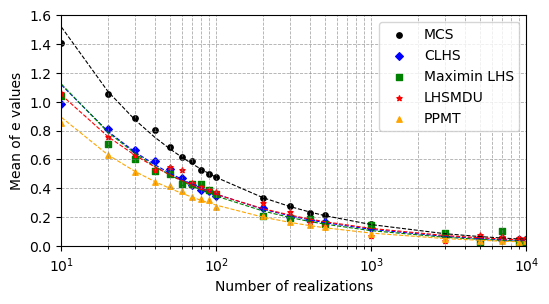

In [85]:
mpl.style.use('default')
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter (e_vals_depen ['reals'], e_vals_depen ['mcs_diff'], s = 15, color = 'black', marker = 'o', label = 'MCS')
ax.plot (e_vals_depen ['reals'], e_vals_depen ['mcs_fit'], color = 'black', linestyle = 'dashed', lw = 0.8)
ax.scatter (e_vals_depen ['reals'], e_vals_depen ['clhs_diff'], s = 15, color = 'blue', marker = 'D', label = 'CLHS')
ax.plot (e_vals_depen ['reals'], e_vals_depen ['clhs_fit'], color = 'blue', linestyle = 'dashed', lw = 0.8)
ax.scatter (e_vals_depen ['reals'], e_vals_depen ['maximin_diff'], s = 15, color = 'green', marker = 's', label = 'Maximin LHS')
ax.plot (e_vals_depen ['reals'], e_vals_depen ['maxi_fit'], color = 'green', linestyle = 'dashed', lw = 0.8)
ax.scatter (e_vals_depen ['reals'], e_vals_depen ['lhsmdu_diff'], s = 15, color = 'red', marker = '*', label = 'LHSMDU')
ax.plot (e_vals_depen ['reals'], e_vals_depen ['lhsmdu_fit'], color = 'red', linestyle = 'dashed', lw = 0.8)
ax.scatter (e_vals_depen ['reals'], e_vals_depen ['ppmt_diff'], s = 15, color = 'orange', marker = '^', label = 'PPMT')
ax.plot (e_vals_depen ['reals'], e_vals_depen ['ppmt'], color = 'orange', linestyle = 'dashed', lw = 0.8)
ax.legend (loc = 1, frameon = True)
ax.set_xlim (10, 10000)
ax.set_ylim (0, 1.6)
#plt.grid (linestyle='--', linewidth=0.5)
ax.set_xlabel ('Number of realizations')
ax.set_ylabel ('Mean of e values')
ax.set_xscale('log')
ax.grid (color = 'gray', linestyle = '--', linewidth = 0.6, which = 'both', alpha = 0.65)

plt.savefig (outdir + 'figures/figure_8.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Calculate the CDF of MCS OOIP samples

In [86]:
x_samp_mcs_core = []
for i in range (20):
    i = []
    x_samp_mcs_core.append (i)

y_samp_mcs_core = []
for i in range (20):
    i = []
    y_samp_mcs_core.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for j in range (100):
        f, g = ecdf (g_reals_corr [i][j])
        x_samp_mcs_core [i].append (f)
        y_samp_mcs_core [i].append (g)
        del f
        del g      

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Calculate the CDF of CLHS OOIP samples

In [87]:
x_samp_clhs_core = []
for i in range (20):
    i = []
    x_samp_clhs_core.append (i)


y_samp_clhs_core = []
for i in range (20):
    i = []
    y_samp_clhs_core.append (i)

for i in tqdm_notebook (range (20), total = 20, desc = 'Loop 1'):
    for j in range (100):
        f, g = ecdf (g_reals_clhs_corr  [i][j])
        x_samp_clhs_core [i].append (f)
        y_samp_clhs_core [i].append (g)
        del f
        del g    

Loop 1:   0%|          | 0/20 [00:00<?, ?it/s]

#### Calculate the CDF of MAXIMIN OOIP samples

In [88]:
x_samp_maxi_core = []
for i in range (20):
    i = []
    x_samp_maxi_core.append (i)


y_samp_maxi_core = []
for i in range (20):
    i = []
    y_samp_maxi_core.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 1'):
    for j in range (100):
        f, g = ecdf (g_reals_maxi_corr [i][j])
        x_samp_maxi_core [i].append (f)
        y_samp_maxi_core [i].append (g)
        del f
        del g
        

Loop 1:   0%|          | 0/10 [00:00<?, ?it/s]

#### Calculate the CDF of LHSMDU OOIP samples

In [89]:
x_samp_mdu_core = []
for i in range (20):
    i = []
    x_samp_mdu_core.append (i)

y_samp_mdu_core = []
for i in range (20):
    i = []
    y_samp_mdu_core.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 1'):
    for j in range (100):
        f, g = ecdf (g_reals_mdulsh_corr [i][j])
        x_samp_mdu_core [i].append (f)
        y_samp_mdu_core [i].append (g)
        del f
        del g
        

Loop 1:   0%|          | 0/10 [00:00<?, ?it/s]

#### Calculate the CDF of PPMT OOIP samples

In [90]:
x_samp_ppmt_core = []
for i in range (20):
    i = []
    x_samp_ppmt_core.append (i)


y_samp_ppmt_core = []
for i in range (20):
    i = []
    y_samp_ppmt_core.append (i)

for i in tqdm_notebook (range (10), total = 10, desc = 'Loop 1'):
    for j in range (100):
        f, g = ecdf (g_reals_ppmt_samp_corr  [i][j])
        x_samp_ppmt_core [i].append (f)
        y_samp_ppmt_core [i].append (g)
        del f
        del g
        

Loop 1:   0%|          | 0/10 [00:00<?, ?it/s]

#### Plot the CDFs of the sample OOIP and truth

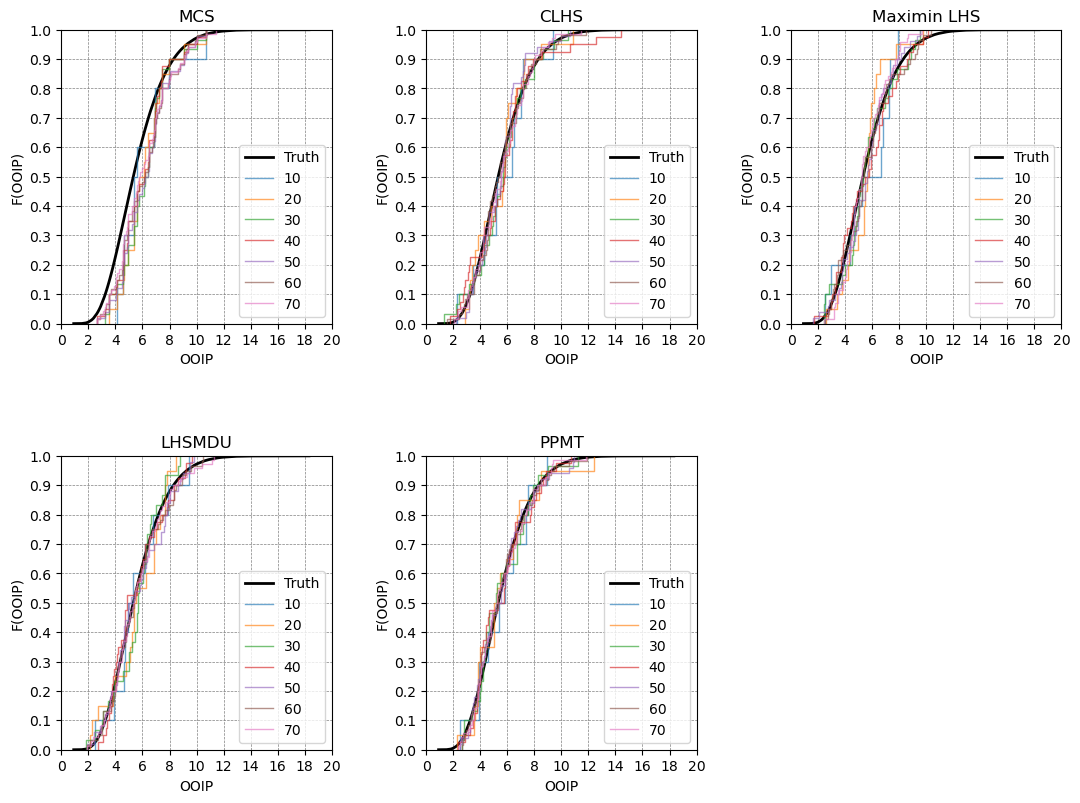

In [91]:
mpl.style.use('default')
fig, axes = plt.subplots(2, 3, figsize = (16, 9)) 

axes [0, 0].plot (x_popul_core, y_popul_core, linestyle = '-', linewidth = 2, color = 'black', label = 'Truth')
sns.ecdfplot (x_samp_mcs_core[0][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '10')
sns.ecdfplot (x_samp_mcs_core[1][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '20')
sns.ecdfplot (x_samp_mcs_core[2][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '30')
sns.ecdfplot (x_samp_mcs_core[3][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '40')
sns.ecdfplot (x_samp_mcs_core[4][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '50')
sns.ecdfplot (x_samp_mcs_core[5][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '60')
sns.ecdfplot (x_samp_mcs_core[6][0], ax = axes [0, 0], linewidth = 1, alpha = 0.65, label = '70')
axes[0, 0].legend (frameon = True, loc = 4)
axes[0, 0].set (xlabel = 'OOIP', ylabel = 'F(OOIP)')
axes[0, 0].set_title ('MCS')
axes[0, 0].set_xlim (0, 16)
axes[0, 0].set_ylim (0, 1)
axes [0, 0].set_yticks (np.arange(0,1.1,0.1))
axes [0, 0].set_xticks (np.arange(0,21,2))
axes [0, 0].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [0, 1].plot (x_popul_core, y_popul_core, linestyle = '-', linewidth = 2, color = 'black', label = 'Truth')
sns.ecdfplot (x_samp_clhs_core [0][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '10')
sns.ecdfplot (x_samp_clhs_core [1][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '20')
sns.ecdfplot (x_samp_clhs_core [2][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '30')
sns.ecdfplot (x_samp_clhs_core [3][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '40')
sns.ecdfplot (x_samp_clhs_core [4][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '50')
sns.ecdfplot (x_samp_clhs_core [5][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '60')
sns.ecdfplot (x_samp_clhs_core [6][1], ax = axes [0, 1], linewidth = 1, alpha = 0.65, label = '70')
axes[0, 1].legend (frameon = True, loc = 4)
axes [0, 1].set (xlabel = 'OOIP', ylabel = 'F(OOIP)')
axes[0, 1].set_title ('CLHS')
plt.xlim (0, 16)
plt.ylim (0, 1)
axes [0, 1].set_yticks (np.arange(0,1.1,0.1))
axes [0, 1].set_xticks (np.arange(0,21,2))
axes [0, 1].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [0, 2].plot (x_popul_core, y_popul_core, linestyle = '-', linewidth = 2, color = 'black', label = 'Truth')
sns.ecdfplot (x_samp_maxi_core [0][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '10')
sns.ecdfplot (x_samp_maxi_core [1][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '20')
sns.ecdfplot (x_samp_maxi_core [2][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '30')
sns.ecdfplot (x_samp_maxi_core [3][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '40')
sns.ecdfplot (x_samp_maxi_core [4][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '50')
sns.ecdfplot (x_samp_maxi_core [5][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '60')
sns.ecdfplot (x_samp_maxi_core [6][2], ax = axes [0, 2], linewidth = 1, alpha = 0.65, label = '70')
axes[0, 2].legend (frameon = True, loc = 4)
axes [0, 2].set (xlabel = 'OOIP', ylabel = 'F(OOIP)')
axes[0, 2].set_title ('Maximin LHS')
plt.xlim (0, 16)
plt.ylim (0, 1)
axes [0, 2].set_yticks (np.arange(0,1.1,0.1))
axes [0, 2].set_xticks (np.arange(0,21,2))
axes [0, 2].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

axes [1, 0].plot (x_popul_core, y_popul_core, linestyle = '-', linewidth = 2, color = 'black', label = 'Truth')
sns.ecdfplot (x_samp_mdu_core [0][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '10')
sns.ecdfplot (x_samp_mdu_core [1][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '20')
sns.ecdfplot (x_samp_mdu_core [2][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '30')
sns.ecdfplot (x_samp_mdu_core [3][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '40')
sns.ecdfplot (x_samp_mdu_core [4][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '50')
sns.ecdfplot (x_samp_mdu_core [5][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '60')
sns.ecdfplot (x_samp_mdu_core [6][3], ax = axes [1, 0], linewidth = 1, alpha = 0.65, label = '70')
axes[1, 0].legend (frameon = True, loc = 4)
axes[1, 0].set (xlabel = 'OOIP', ylabel = 'F(OOIP)')
axes[1, 0].set_title ('LHSMDU')
plt.xlim (0, 16)
plt.ylim (0, 1)
axes [1, 0].set_yticks (np.arange(0,1.1,0.1))
axes [1, 0].set_xticks (np.arange(0,21,2))
axes [1, 0].grid (color = 'gray', linestyle = '--', linewidth = 0.5)


axes [1, 1].plot (x_popul_core, y_popul_core, linestyle = '-', linewidth = 2, color = 'black', label = 'Truth')
sns.ecdfplot (x_samp_ppmt_core [0][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '10')
sns.ecdfplot (x_samp_ppmt_core [1][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '20')
sns.ecdfplot (x_samp_ppmt_core [2][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '30')
sns.ecdfplot (x_samp_ppmt_core [3][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '40')
sns.ecdfplot (x_samp_ppmt_core [4][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '50')
sns.ecdfplot (x_samp_ppmt_core [5][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '60')
sns.ecdfplot (x_samp_ppmt_core [6][4], ax = axes [1, 1], linewidth = 1, alpha = 0.65, label = '70')
axes[1, 1].legend (frameon = True, loc = 4)
axes[1, 1].set (xlabel = 'OOIP', ylabel = 'F(OOIP)')
axes[1, 1].set_title ('PPMT')
plt.xlim (0, 16)
plt.ylim (0, 1)
axes [1, 1].set_yticks (np.arange(0,1.1,0.1))
axes [1, 1].set_xticks (np.arange(0,21,2))
axes [1, 1].grid (color = 'gray', linestyle = '--', linewidth = 0.5)

fig.delaxes (axes[1][2])

plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 0.75, top = 0.9, wspace = 0.35, hspace = 0.45)        
plt.savefig (outdir + 'figures/figure_9.png', bbox_inches = 'tight', dpi = 300)
plt.show ()

#### Clean up the directory

The following code will clean up the directory. Please use (Ctrl and /) to activate the code.

In [92]:
# figures = []

# for i in range (9):
#     i = i + 1
#     z = './output/figures/figure_{}.png'.format (i)
#     figures.append (z)

    
# list_of_reals = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 3000, 5000, 
#                  7000, 9000, 10000]

# lhsmdus = []
# for i in range (100):
#     i = i + 1
#     for j in list_of_reals:
#         k = './output/lhsmdu/lhsmdu_{}_{}.out'.format (i, j)
#         lhsmdus.append (k)
    
# mcs_ppmt = []
# for i in range (100):
#     i = i + 1
#     for j in list_of_reals:
#         k = './output/ppmt/datafl_{}_{}.out'.format (i, j)
#         mcs_ppmt.append (k)
        
# ppmt = []
# for i in range (100):
#     i = i + 1
#     for j in list_of_reals:
#         k = './output/ppmt/ppmt_1/ppmt_{}_{}.out'.format (i, j)
#         ppmt.append (k)

# files = [figures, lhsmdus, mcs_ppmt, ppmt]

# gs.rmfile (['temp', 'nofile', 'nofilr'])

# for i in files:
#     gs.rmfile (i)